# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow those simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 4th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis). 


**Important note:**
In the below exercises, it is expected that the HTML content pages for each artist, exist in a folder called `artist_pages` 

In [139]:
# Core Data Handling and Math
import pandas as pd
import numpy as np
import math
import statistics
from collections import Counter, defaultdict, OrderedDict
import json

# Graph and Network Analysis
import networkx as nx
from networkx.algorithms.community import louvain_communities

# File/System Operations and Progress Tracking
import os
import glob
from tqdm.auto import tqdm # Use tqdm.auto for notebook compatibility

# Text Processing and Web Scraping
import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud

# Utility (less commonly used)
import random
import requests


# Part 1: Analyze the network

The questions in this part are based on Lecture 5.

* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   - I would like you to include concepts like centrality and assortativity in your analysis.
   - Use a network backbone in your analysis.
   - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   - **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network. 


In [140]:
# Folder with the artist pages
folder = "artist_pages"

# Build artist list from the filenames in the folder
artists = [os.path.splitext(f)[0].replace("_", " ") 
           for f in os.listdir(folder) if f.endswith(".txt")]

artist_set = set(artists)  # for fast lookup

# Regex to extract links
link_pattern = re.compile(r"\[\[([^\]|]+)(?:\|([^\]]+))?\]\]")

def extract_links(artist_name, folder="artist_pages"): 
    path = os.path.join(folder, f"{artist_name.replace(' ', '_')}.txt")
    if not os.path.exists(path):
        return [], 0
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    # Extract targets that exist in our artist set
    targets = link_pattern.findall(text)
    valid_targets = [display if display else page for page, display in targets 
                     if (display if display else page) in artist_set]
    # Word count
    word_count = len(re.findall(r"\b\w+\b", text))
    return valid_targets, word_count

# Build directed graph
G = nx.DiGraph()
for artist in artists:
    targets, word_count = extract_links(artist)
    G.add_node(artist, content_length=word_count)
    for t in targets:
        G.add_edge(artist, t)

# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Take largest weakly connected component
if G.number_of_nodes() > 0:
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()
    print(f"Largest component: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")
else:
    print("Graph is empty! Check your artist_pages folder.")

Largest component: 476 nodes, 6539 edges


<span style="color:lightblue"> The network’s largest weakly connected component contains 476 performers connected by 6539 directed links. This is the main portion of the network we analyze, since isolated nodes or tiny disconnected subgraphs are not very informative. </span>

In [141]:
num_nodes = G_largest.number_of_nodes()
num_edges = G_largest.number_of_edges()
density = nx.density(G_largest)
avg_degree = sum(dict(G_largest.degree()).values()) / num_nodes

print(f"Nodes: {num_nodes}, Edges: {num_edges}")
print(f"Density: {density:.4f}, Average degree: {avg_degree:.2f}")

Nodes: 476, Edges: 6539
Density: 0.0289, Average degree: 27.47


<span style="color:lightblue"> The network is sparse, with a density of only 0.0289, meaning only ~2.9% of all possible edges exist. The average degree is 27.47, indicating that each performer links to or is linked by roughly 27 other performers on average. Sparse networks like this are typical for large networks of Wikipedia pages. </span>

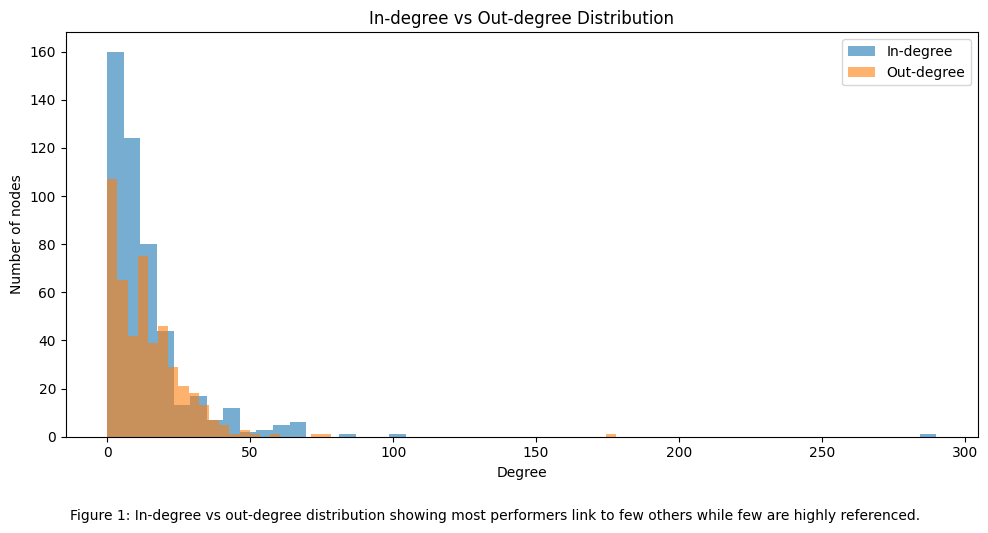

In [142]:
import matplotlib.pyplot as plt

in_deg = [d for _, d in G_largest.in_degree()]
out_deg = [d for _, d in G_largest.out_degree()]

plt.figure(figsize=(10,5))
plt.hist(in_deg, bins=50, alpha=0.6, label='In-degree')
plt.hist(out_deg, bins=50, alpha=0.6, label='Out-degree')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.legend()
plt.title("In-degree vs Out-degree Distribution")

plt.figtext(0.5, -0.05, "Figure 1: In-degree vs out-degree distribution showing most performers link to few others while few are highly referenced.", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


<span style="color:lightblue"> Here we plot the in-degree and out-degree distributions. The in-degree shows how many other artists link to a performer, while out-degree shows how many links a performer makes. Overall we see that they correspond properly to the average degree of 27.47. </span>


In [143]:
deg_cent = nx.degree_centrality(G_largest)
btw_cent = nx.betweenness_centrality(G_largest)
eig_cent = nx.eigenvector_centrality(G_largest, max_iter=500)

top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_btw = sorted(btw_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_eig = sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 by degree centrality:", top_deg)
print("Top 5 by betweenness centrality:", top_btw)
print("Top 5 by eigenvector centrality:", top_eig)

Top 5 by degree centrality: [('AllMusic', 0.6168421052631579), ('rock music', 0.3894736842105263), ('Led Zeppelin', 0.2736842105263158), ('Alice in Chains', 0.24842105263157893), ('Black Sabbath', 0.24210526315789474)]
Top 5 by betweenness centrality: [('Deep Purple', 0.03847113996137522), ('rock music', 0.03751368025395961), ('Jimi Hendrix', 0.03735369863001993), ('Alice in Chains', 0.03333361555403584), ('Led Zeppelin', 0.03052451329269523)]
Top 5 by eigenvector centrality: [('AllMusic', 0.41045734071229656), ('Led Zeppelin', 0.2002344932942127), ('Bob Dylan', 0.17201041802038516), ('Elvis Presley', 0.1596520653092491), ('John Lennon', 0.15764569202571216)]


<span style="color:lightblue"> Degree centrality highlights nodes with the most connections (AllMusic, rock music, Led Zeppelin). Betweenness centrality identifies performers acting as “bridges” in the network (Deep Purple, Jimi Hendrix), which often connect subgroups or genres. Eigenvector centrality shows influential performers connected to other influential performers (AllMusic, Led Zeppelin, Bob Dylan). Together, these measures provide complementary insights into network importance. </span>

In [144]:
assort = nx.degree_assortativity_coefficient(G_largest)
print(f"Degree assortativity: {assort:.3f}")

Degree assortativity: -0.075


<span style="color:lightblue"> The slightly negative assortativity indicates that high-degree nodes (popular performers) tend to link to low-degree nodes rather than other high-degree nodes. This makes sense in Wikipedia networks: famous bands are often linked from many lesser-known artists’ pages. </span>

In [145]:
threshold = 2  # keep edges where source out-degree >=2 and target in-degree >=2
backbone_edges = [(u,v) for u,v in G_largest.edges() if G_largest.out_degree(u) >= threshold and G_largest.in_degree(v) >= threshold]
G_backbone = G_largest.edge_subgraph(backbone_edges).copy()
print(f"Backbone edges: {G_backbone.number_of_edges()}")

Backbone edges: 6501


<span style="color:lightblue"> After filtering edges to keep only the most significant connections (source out-degree ≥2, target in-degree ≥2), the network backbone still retains almost all edges (6501 of 6539). This suggests that most links are meaningful, connecting performers who are referenced multiple times, and the backbone preserves the network’s main structure for visualization. </span>

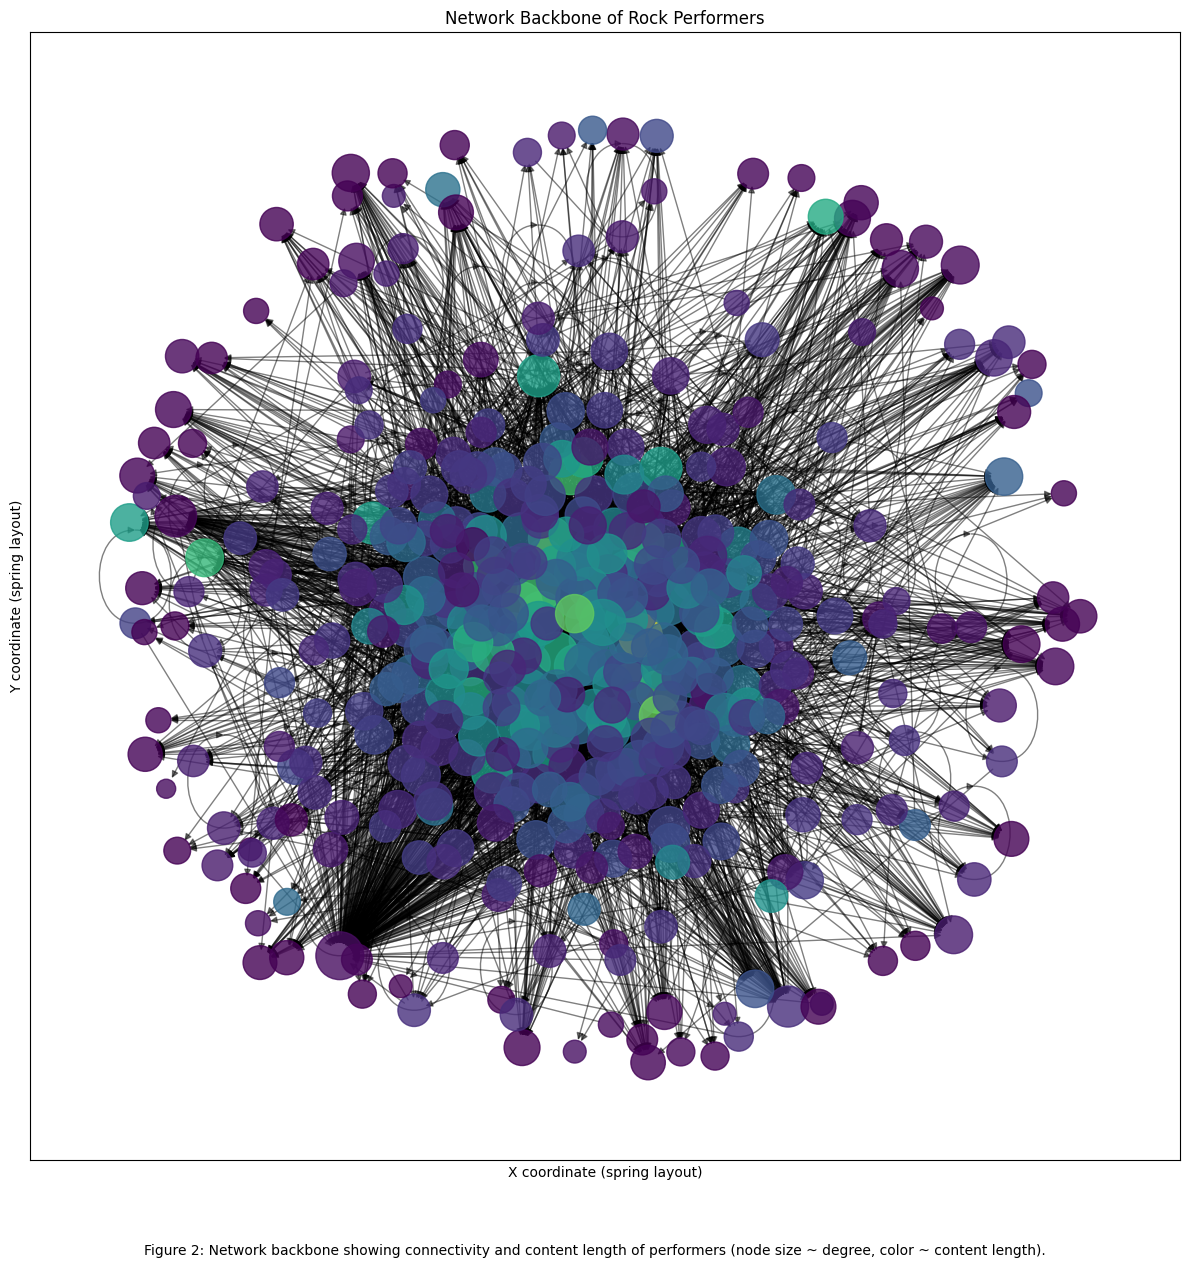

In [146]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_backbone, k=0.5, seed=42)
nx.draw_networkx_nodes(
    G_backbone, pos, 
    node_size=[50 + 200*np.log1p(G_backbone.degree(n)) for n in G_backbone.nodes()],
    node_color=[G_backbone.nodes[n]['content_length'] for n in G_backbone.nodes()],
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_backbone, pos, alpha=0.5)

plt.title("Network Backbone of Rock Performers")
plt.xlabel("X coordinate (spring layout)")
plt.ylabel("Y coordinate (spring layout)")
plt.axis('on')  # turn axes on so labels are visible

plt.figtext(0.5, -0.05, 
            "Figure 2: Network backbone showing connectivity and content length of performers (node size ~ degree, color ~ content length).",
            ha='center', fontsize=10)

plt.tight_layout()
plt.show()


<span style="color:lightblue"> We analyzed the largest weakly connected component of the rock performers network, which contains 476 nodes and 6,539 edges. The network is sparse (density 0.0289) with an average degree of 27.47. In-degree and out-degree distributions show that a few performers, such as *AllMusic* and *Led Zeppelin*, are highly referenced, while most performers link to only a few others. Centrality measures highlight influential nodes: degree centrality identifies the most connected performers, betweenness centrality identifies bridging performers, and eigenvector centrality identifies nodes connected to other influential nodes. The network exhibits slightly negative assortativity (-0.075), indicating that high-degree performers tend to link to lower-degree performers. Constructing a backbone network preserves almost all edges (6,501), simplifying visualization while maintaining core structure. Overall, the analysis characterizes the network in terms of connectivity, influence, and structural importance, revealing which performers dominate references and act as connectors between groups. </span>


# Part 2: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.


<span style="color:lightblue">
To find the communities formed by the bands, we will first extract the information about their genres and add this as a node attribute in our network. To do so, we will use the "infobox" found in the Wikipedia pages. 
</span>

In [147]:
def extract_genres_from_infobox(text):
    """
    Extracts the list of genres from the 'Infobox musical artist' wikitext.
    Maintains the order of genres as they appear in the infobox.

    Args:
        text (str): The complete wikitext of the Wikipedia page.

    Returns:
        list: A list of cleaned genre names (lowercase), in order of appearance.
    """
    
    # First, find the infobox in the text
    infobox_patterns = [
        r'\{\{[Ii]nfobox\s+musical\s+artist(.*?)\n\}\}',
        r'\{\{[Ii]nfobox\s+band(.*?)\n\}\}',
        r'\{\{[Ii]nfobox\s+person(.*?)\n\}\}',
        r'\{\{[Ii]nfobox\s+singer(.*?)\n\}\}'
    ]
    
    infobox_text = None
    for pattern in infobox_patterns:
        infobox_match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
        if infobox_match:
            infobox_text = infobox_match.group(1)
            break
    
    if not infobox_text:
        return []
    
    # Look for genre field
    genre_patterns = [
        r'\|\s*genres?\s*=\s*(.*?)(?=\n\s*\||\n\}\}|$)',  # genre or genres
        r'\|\s*style\s*=\s*(.*?)(?=\n\s*\||\n\}\}|$)',    # sometimes called style
    ]
    
    raw_genre_content = None
    for pattern in genre_patterns:
        genre_match = re.search(pattern, infobox_text, re.DOTALL | re.IGNORECASE)
        if genre_match:
            raw_genre_content = genre_match.group(1).strip()
            break
    
    if not raw_genre_content:
        return []
    
    genres = []  # Use list to maintain order
    
    # Handle flatlist specifically first (maintains order)
    if '{{flatlist|' in raw_genre_content.lower():
        flatlist_match = re.search(r'\{\{flatlist\|(.*?)\}\}', raw_genre_content, re.DOTALL | re.IGNORECASE)
        if flatlist_match:
            flatlist_content = flatlist_match.group(1)
            # Extract wiki links in order
            wiki_links = re.findall(r'\[\[([^|\]]+)(?:\|[^\]]+)?\]\]', flatlist_content)
            for link in wiki_links:
                clean_genre = link.strip().lower()
                if (not any(skip in clean_genre for skip in ['file:', 'category:', 'image:', 'cite', 'ref', 'allmusic', 'oxford', 'scotsman', 'riff']) and
                    (any(music_term in clean_genre for music_term in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'electronic', 'hip hop', 'rap', 'reggae', 'ska', 'funk', 'soul', 'indie', 'alternative', 'grunge', 'britpop', 'post-', 'new wave', 'disco', 'dance', 'house', 'techno', 'ambient', 'classical', 'opera', 'gospel', 'r&b', 'rhythm', 'power pop']) or
                     clean_genre in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'electronic', 'hip hop', 'rap', 'reggae', 'ska', 'funk', 'soul'])):
                    if clean_genre not in genres:  # Avoid duplicates while maintaining order
                        genres.append(clean_genre)
    
    # Method 1: Extract from wiki links [[Genre Name]] (if no flatlist found)
    if not genres:
        wiki_links = re.findall(r'\[\[([^|\]]+)(?:\|[^\]]+)?\]\]', raw_genre_content)
        for link in wiki_links:
            clean_genre = link.strip().lower()
            # Skip non-genre links and check if it's actually a music genre
            if (not any(skip in clean_genre for skip in ['file:', 'category:', 'image:', 'cite', 'ref', 'allmusic', 'oxford', 'scotsman', 'riff']) and
                (any(music_term in clean_genre for music_term in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'electronic', 'hip hop', 'rap', 'reggae', 'ska', 'funk', 'soul', 'indie', 'alternative', 'grunge', 'britpop', 'post-', 'new wave', 'disco', 'dance', 'house', 'techno', 'ambient', 'classical', 'opera', 'gospel', 'r&b', 'rhythm', 'power pop']) or
                 clean_genre in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'electronic', 'hip hop', 'rap', 'reggae', 'ska', 'funk', 'soul'])):
                if clean_genre not in genres:  # Avoid duplicates while maintaining order
                    genres.append(clean_genre)
    
    # Method 2: If no wiki links found, try other formats
    if not genres:
        # Remove references and citations first
        clean_content = re.sub(r'<ref[^>]*>.*?</ref>', '', raw_genre_content, flags=re.DOTALL)
        clean_content = re.sub(r'<[^>]+>', '', clean_content)
        clean_content = re.sub(r'\{\{[^}]+\}\}', '', clean_content)
        clean_content = re.sub(r'\[\[[^]]+\]\]', '', clean_content)
        
        # Split by common separators
        potential_genres = re.split(r'[,;•\n\*]+', clean_content)
        for genre in potential_genres:
            clean_genre = genre.strip().lower()
            if (clean_genre and len(clean_genre) > 2 and 
                any(music_term in clean_genre for music_term in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'new wave', 'grunge', 'power pop'])):
                if clean_genre not in genres:  # Avoid duplicates while maintaining order
                    genres.append(clean_genre)

    # Normalize common variations while maintaining order
    normalized_genres = []
    for genre in genres:
        # Common normalizations
        genre = genre.replace("rock'n'roll", "rock and roll")
        genre = genre.replace("rock & roll", "rock and roll")
        genre = genre.replace("r&b", "rhythm and blues")
        genre = genre.replace("rnb", "rhythm and blues")
        genre = genre.replace("hip-hop", "hip hop")
        genre = genre.replace("electro", "electronic")
        genre = genre.replace("alt rock", "alternative rock")
        genre = genre.replace("rhythm & blues", "rhythm and blues")
        genre = genre.replace("new wave music", "new wave")
        genre = genre.replace("rock music", "rock")
        genre = genre.replace(" music", "")  # Remove " music" suffix
        genre = genre.replace("british rock and roll", "rock and roll")
        genre = re.sub(r'\s+', ' ', genre).strip()  # Clean whitespace
        
        if genre and len(genre) > 1 and genre not in normalized_genres:
            normalized_genres.append(genre)
    
    return normalized_genres  # Return list maintaining order

In [148]:
def extract_all_genres():
    """Extract genres for all artists in your network"""
    artist_genres = {}
    no_genres_count = 0
    
    folder = "artist_pages"
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            # Get artist name from filename
            artist_name = filename.replace(".txt", "").replace("_", " ")
            
            # Read the file
            filepath = os.path.join(folder, filename)
            with open(filepath, "r", encoding="utf-8") as f:
                text = f.read()
            
            # Extract genres
            genres = extract_genres_from_infobox(text)
            
            if genres:
                artist_genres[artist_name] = genres
                #print(f"{artist_name}: {genres}")
            else:
                no_genres_count += 1
                #print(f"{artist_name}: No genres found")
    
    print(f"\nDone!")
    
    return artist_genres

# Run it
all_genres = extract_all_genres()


Done!



Statistics:
Number of nodes with genres: 336
Average genres per node: 3.15
Total distinct genres: 145

Top 15 genres:


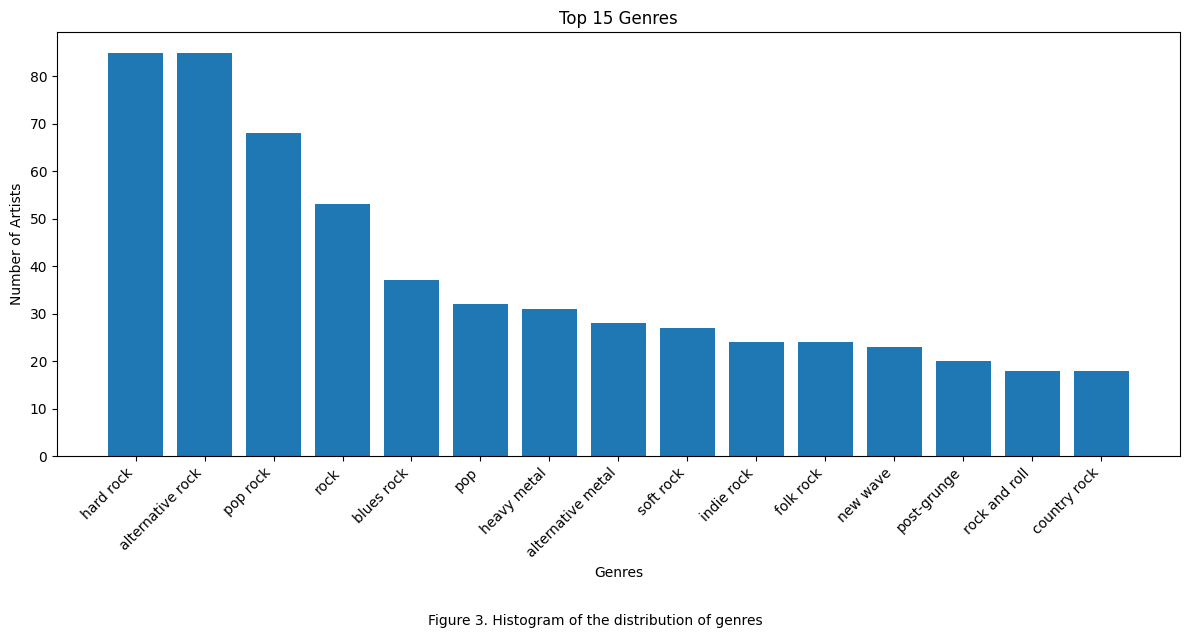

In [149]:
# Calculate statistics
if all_genres:
    # Number of nodes with genres
    nodes_with_genres = len(all_genres)
    
    # Average number of genres per node
    total_genres = sum(len(genres) for genres in all_genres.values())
    avg_genres = total_genres / nodes_with_genres
    
    # Total distinct genres
    all_unique_genres = set()
    for genres in all_genres.values():
        all_unique_genres.update(genres)
    distinct_genres = len(all_unique_genres)
    #print(all_unique_genres)
    
    # Count frequency of each genre
    genre_counts = {}
    for genres in all_genres.values():
        for genre in genres:
            genre_counts[genre] = genre_counts.get(genre, 0) + 1
    
    # Top 15 genres
    top_15_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:15]
    
    print(f"\nStatistics:")
    print(f"Number of nodes with genres: {nodes_with_genres}")
    print(f"Average genres per node: {avg_genres:.2f}")
    print(f"Total distinct genres: {distinct_genres}")
    print(f"\nTop 15 genres:")
    #for genre, count in top_15_genres:
        #print(f"  {genre}: {count}")
    
    # Create histogram
    import matplotlib.pyplot as plt
    
    genres, counts = zip(*top_15_genres)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(genres)), counts)
    plt.xlabel('Genres')
    plt.ylabel('Number of Artists')
    plt.title('Top 15 Genres')
    plt.xticks(range(len(genres)), genres, rotation=45, ha='right')
    plt.tight_layout()
    #plt.figtext(0.5, -0.05, "Figure X. Histogram of the distribution of genres", wrap=True, horizontalalignment='center', fontsize=10)
    plt.show()


<span style="color:lightblue">

With the designed code, we could find the genres of 420 artis. On average, each artist is defined by 3 genres, and over all the network, 160 different genres were found. In Figre X, the top 15 genres are displayed. 

</span>

<span style="color:lightblue">

Now, we will add the genre information as a node attribute to the network. For each artist, we will only keep its first genre. 

</span>

In [150]:
# import network
import requests

url = "https://raw.githubusercontent.com/albapim/Social_Graphs_Assignments/refs/heads/main/rock_performers_graph.gexf"
r = requests.get(url)
with open("rock_performers_graph.gexf", "wb") as f:
    f.write(r.content)

# Load the rock music network from the GEXF file
rock_network = nx.read_gexf("rock_performers_graph.gexf")

# make the network undirected
rock_network = rock_network.to_undirected()

In [151]:
def convert_name_to_node_format(artist_name):
    """Convert artist name to match network node format"""
    # Start with the basic space to underscore conversion
    node_name = artist_name.replace(" ", "_")
    
    # Handle special characters that might be encoded differently
    # Check if the simple conversion exists first
    if node_name in rock_network.nodes():
        return node_name
    
    # Try different variations for common special characters
    variations = [
        node_name,
        node_name.replace("'", "%27"),  # URL encoding for apostrophe
        node_name.replace("&", "%26"),  # URL encoding for ampersand
        node_name.replace(",", "%2C"),  # URL encoding for comma
        node_name.replace("'", ""),     # Remove apostrophe completely
        node_name.replace("&", "and"),  # Replace & with "and"
        node_name.replace(",", ""),     # Remove comma completely
    ]
    
    # Check which variation exists in the network
    for variation in variations:
        if variation in rock_network.nodes():
            return variation
    
    return node_name  # Return original if no match found

# Fix the key mismatch with better name conversion
all_genres_fixed = {}
all_genres_fixed2 = {}
for artist, genres in all_genres.items():
    node_name = convert_name_to_node_format(artist)
    all_genres_fixed[node_name] = genres[0] if genres else None
    all_genres_fixed2[node_name] = genres if genres else None

# Now set the node attributes with the corrected keys
nx.set_node_attributes(rock_network, all_genres_fixed, 'genre')
nx.set_node_attributes(rock_network, all_genres_fixed2, 'all_genres')

# Remove nodes that don't have genres
nodes_to_remove = [node for node in rock_network.nodes() if 'genre' not in rock_network.nodes[node] or rock_network.nodes[node]['genre'] is None]
rock_network.remove_nodes_from(nodes_to_remove)

print(f"Final network size: {rock_network.number_of_nodes()}")
print(f"Nodes removed: {len(nodes_to_remove)}")

# Verify it worked
print("\nSample nodes with their genre attribute:")
for node in list(rock_network.nodes())[15:20]:
    genre = rock_network.nodes[node].get('genre', 'No genre')
    print(f"{node}: {genre}")
    genre = rock_network.nodes[node].get('all_genres', 'No genre')
    print(f"{node}: {genre}")

Final network size: 417
Nodes removed: 68

Sample nodes with their genre attribute:
Thirty_Seconds_to_Mars: alternative rock
Thirty_Seconds_to_Mars: ['alternative rock']
Black_Stone_Cherry: hard rock
Black_Stone_Cherry: ['hard rock', 'southern rock']
The_Pretenders: rock
The_Pretenders: ['rock', 'pop rock', 'new wave', 'alternative rock']
10cc: art rock
10cc: ['art rock', 'art pop', 'progressive pop', 'soft rock', 'pop rock']
Eric_Clapton: rock
Eric_Clapton: ['rock', 'blues']


<span style="color:lightblue">

Now that we have the genres, we can see how these define communities. For this, we will use the concept of modularity, which tells us if a given partition could be forming a community. To do so, modularity compares the number of links we would find by chance to the number of links found in the actual partition. If there are more links in the actual partition, it would mean we could have a community. 

<span>


In [152]:
G_main = rock_network

In [153]:
# Calculate modularity for each genre-based community

def calculate_community_modularity(G, community_nodes):
    """
    Calculate modularity for a single community using the formula:
    Mc = Lc/L - (kc/2L)^2
    
    Args:
        G: NetworkX graph
        community_nodes: list of nodes in the community
        
    Returns:
        float: modularity value for the community
    """
    # Total number of edges in the graph
    L = G.number_of_edges()
    
    if L == 0:
        return 0
    
    # Create subgraph for the community
    community_subgraph = G.subgraph(community_nodes)
    
    # Lc: number of edges within the community
    Lc = community_subgraph.number_of_edges()
    
    # kc: sum of degrees of all nodes in the community
    kc = sum(G.degree(node) for node in community_nodes)
    
    # Calculate modularity for this community
    Mc = Lc / L - (kc / (2 * L)) ** 2
    
    return Mc

def calculate_all_communities_modularity(G):
    """
    Calculate modularity for each genre-based community in the graph
    
    Args:
        G: NetworkX graph with 'genre' node attribute
        
    Returns:
        dict: mapping of genre to modularity value
    """
    # Group nodes by genre
    genre_communities = {}
    for node in G.nodes():
        genre = G.nodes[node]['genre']
        if genre not in genre_communities:
            genre_communities[genre] = []
        genre_communities[genre].append(node)
    
    # Calculate modularity for each community
    community_modularities = {}
    for genre, nodes in genre_communities.items():
        modularity = calculate_community_modularity(G, nodes)
        community_modularities[genre] = modularity
        print(f"Genre '{genre}': {len(nodes)} nodes, modularity = {modularity:.4f}")
    
    return community_modularities

# Calculate modularity for all genre-based communities
print("Calculating modularity for each genre-based community:")
modularities = calculate_all_communities_modularity(G_main)

# Total modularity (sum of all community modularities)
total_modularity = sum(modularities.values())
print(f"\nTotal network modularity: {total_modularity:.4f}")

# Sort by modularity to see best communities
sorted_modularities = sorted(modularities.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 5 communities by modularity:")
for genre, mod in sorted_modularities[:5]:
    print(f"  {genre}: {mod:.4f}")


Calculating modularity for each genre-based community:
Genre 'thrash metal': 2 nodes, modularity = 0.0002
Genre 'hard rock': 33 nodes, modularity = 0.0094
Genre 'post-grunge': 7 nodes, modularity = 0.0023
Genre 'rock and roll': 13 nodes, modularity = 0.0062
Genre 'alternative rock': 41 nodes, modularity = 0.0072
Genre 'celtic punk': 2 nodes, modularity = 0.0002
Genre 'pop-punk': 8 nodes, modularity = 0.0029
Genre 'rock': 45 nodes, modularity = 0.0135
Genre 'art rock': 4 nodes, modularity = 0.0004
Genre 'nu metal': 3 nodes, modularity = 0.0003
Genre 'grunge': 3 nodes, modularity = 0.0003
Genre 'punk rock': 6 nodes, modularity = 0.0013
Genre 'blues rock': 8 nodes, modularity = 0.0004
Genre 'southern rock': 5 nodes, modularity = 0.0010
Genre 'roots rock': 3 nodes, modularity = -0.0002
Genre 'progressive rock': 7 nodes, modularity = 0.0003
Genre 'heavy metal': 10 nodes, modularity = 0.0045
Genre 'british blues': 2 nodes, modularity = 0.0002
Genre 'post-punk': 3 nodes, modularity = -0.0000


<span style="color:lightblue">

We can observe that by using the first genre of each artist as the basis for community definition yields a low modularity score of $M = 0.1263$. This suggests that this type of partition is a poor fit for the network's structure, as the density of links within the genre communities is only a little bit higher than what would be expected in a randomized network. We believe that a possible cause for this low value is the high degree of fragmentation introduced by using 71 different communities for 420 nodes (an average of $\approx 6$ nodes per community), which is heavily penalized due to the resolution limit that the modularity metric has.

<span>

<span style="color:lightblue">

Now, we will use te Louvain-algorithm to find communities in the network. 

<span>

In [154]:
# modularity
modularity = nx.community.modularity(G_main, nx.community.louvain_communities(G_main))
print(f"Louvain method modularity: {modularity:.4f}")

Louvain method modularity: 0.2973


<span style="color:lightblue">

As it can be observed, this method results in a higher modularity value, suggesting that this partition is significantly more community-like than the genre based partition. This result suggests that there exists a structure in the rock network. 

<span>

Number of communities found: 6

Community-Genre Analysis:
--------------------------------------------------
Community 0 (76 nodes):
  Top genres: [('rock', 18), ('rock and roll', 12), ('folk rock', 6)]
  Example artists: ['Bill_Haley_%26_His_Comets', 'The_Allman_Brothers_Band', 'Jimi_Hendrix']

Community 1 (26 nodes):
  Top genres: [('alternative rock', 3), ('new wave', 3), ('post-punk', 3)]
  Example artists: ['The_Jesus_and_Mary_Chain', 'Billy_Squier', 'Mitch_Ryder']

Community 2 (90 nodes):
  Top genres: [('hard rock', 22), ('alternative metal', 10), ('heavy metal', 10)]
  Example artists: ['The_Cult', 'Korn', 'Alter_Bridge']

Community 3 (56 nodes):
  Top genres: [('alternative rock', 15), ('pop rock', 6), ('indie rock', 5)]
  Example artists: ['Arcade_Fire', 'Radiohead', 'Kaiser_Chiefs']

Community 4 (53 nodes):
  Top genres: [('rock', 16), ('pop rock', 6), ('alternative rock', 4)]
  Example artists: ['Jim_Croce', 'Air_Supply', 'Manfred_Mann_(musician)']

Community 5 (24 nodes):


C:\Users\nick\AppData\Local\Temp\ipykernel_9904\2299178959.py:85: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], s=100, label=f'Community {comm_id} ({size} nodes)')


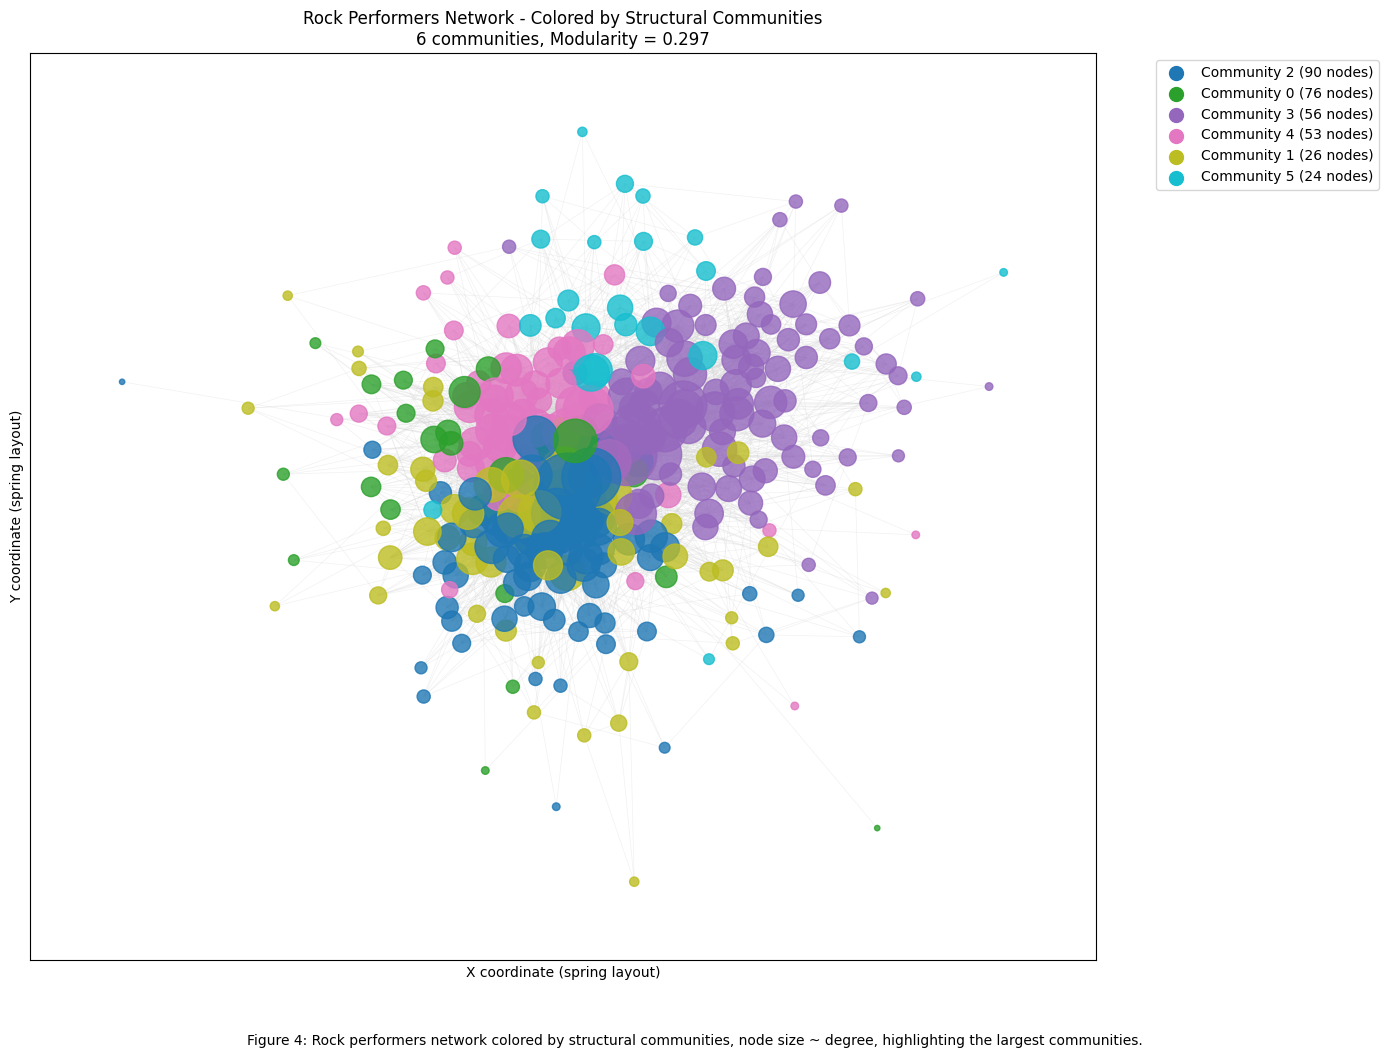


Community Statistics:
Total communities: 6
Largest community size: 90
Smallest community size: 24
Average community size: 54.17


In [155]:
# Find structural communities using Louvain algorithm
louvain_communities = nx.community.louvain_communities(G_main, seed=42)
print(f"Number of communities found: {len(louvain_communities)}")


# Analyze genre composition within each community
print("\nCommunity-Genre Analysis:")
print("-" * 50)

for i, community in enumerate(louvain_communities):
    if len(community) >= 5:  # Only show communities with 5+ nodes
        print(f"Community {i} ({len(community)} nodes):")
        
        # Count genres in this community
        genre_counts = {}
        for node in community:
            if node in G_main.nodes():
                genre = G_main.nodes[node].get('genre')
                genre_counts[genre] = genre_counts.get(genre, 0) + 1
        
        # Sort by frequency
        sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
        
        print(f"  Top genres: {sorted_genres[:3]}")
        print(f"  Example artists: {list(community)[:3]}")
        print()

# Create a mapping from node to community ID
node_to_community = {}
for i, community in enumerate(louvain_communities):
    for node in community:
        node_to_community[node] = i

# Get community sizes and sort by size
community_sizes = [(i, len(community)) for i, community in enumerate(louvain_communities)]
community_sizes.sort(key=lambda x: x[1], reverse=True)
print("Community sizes:", [(i, size) for i, size in community_sizes[:10]])

# Create layout
pos = nx.spring_layout(G_main, seed=42)  # ForceAtlas2 might not be available, using spring

# Get node degrees and community assignments
degrees = [G_main.degree(node) for node in G_main.nodes()]
node_communities = [node_to_community[node] for node in G_main.nodes()]

# Create visualization
plt.figure(figsize=(14, 10))

# If there are many small communities, color only the largest ones
n_largest_communities = min(10, len(louvain_communities))  # Color top 10 communities
largest_community_ids = [comm_id for comm_id, size in community_sizes[:n_largest_communities]]

# Create color mapping
node_colors = []
for node in G_main.nodes():
    comm_id = node_to_community[node]
    if comm_id in largest_community_ids:
        node_colors.append(comm_id)
    else:
        node_colors.append(-1)  # Use -1 for small communities (will be gray)

# Draw edges first
nx.draw_networkx_edges(G_main, pos, edge_color='lightgray', alpha=0.3, width=0.5)

# Draw nodes with colors based on community
# Use a colormap that handles the -1 values for small communities

# Create custom colormap
n_colors = len(largest_community_ids)
colors = cm.tab10(np.linspace(0, 1, n_colors))  # Get distinct colors
cmap = cm.colors.ListedColormap(['lightgray'] + list(colors))

nodes = nx.draw_networkx_nodes(G_main, pos, 
                              node_size=[d*15 for d in degrees],  # size by degree
                              node_color=node_colors,             # color by community
                              cmap=cmap,                          # custom colormap
                              vmin=-1,                            # include gray for small communities
                              vmax=max(largest_community_ids),
                              alpha=0.8)

plt.title(f'Rock Performers Network - Colored by Structural Communities\n{len(louvain_communities)} communities, Modularity = {modularity:.3f}')

# Create legend for largest communities
for i, (comm_id, size) in enumerate(community_sizes[:n_largest_communities]):
    plt.scatter([], [], c=colors[i], s=100, label=f'Community {comm_id} ({size} nodes)')

# Add legend for small communities
if len(louvain_communities) > n_largest_communities:
    small_communities_count = len(louvain_communities) - n_largest_communities
    total_small_nodes = sum(size for comm_id, size in community_sizes[n_largest_communities:])
    plt.scatter([], [], c='lightgray', s=100, 
               label=f'{small_communities_count} small communities ({total_small_nodes} nodes)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xlabel("X coordinate (spring layout)")
plt.ylabel("Y coordinate (spring layout)")
plt.axis('on') 
plt.figtext(0.5, -0.05, "Figure 4: Rock performers network colored by structural communities, node size ~ degree, highlighting the largest communities.", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# Print some statistics about the communities
print(f"\nCommunity Statistics:")
print(f"Total communities: {len(louvain_communities)}")
print(f"Largest community size: {community_sizes[0][1]}")
print(f"Smallest community size: {community_sizes[-1][1]}")
print(f"Average community size: {np.mean([size for _, size in community_sizes]):.2f}")

<span style="color:lightblue">

Now, we will see if the genres align with the communities. 

<span>

Top 7 genres:
  1. alternative rock: 82 nodes
  2. hard rock: 80 nodes
  3. pop rock: 67 nodes
  4. rock: 52 nodes
  5. blues rock: 36 nodes
  6. pop: 32 nodes
  7. alternative metal: 28 nodes

Top 5 communities:
  1. Community 2: 90 nodes
  2. Community 0: 76 nodes
  3. Community 3: 56 nodes
  4. Community 4: 53 nodes
  5. Community 1: 26 nodes

Confusion Matrix D (7 genres × 5 communities):
Rows = Genres, Columns = Communities
Matrix shape: (7, 5)


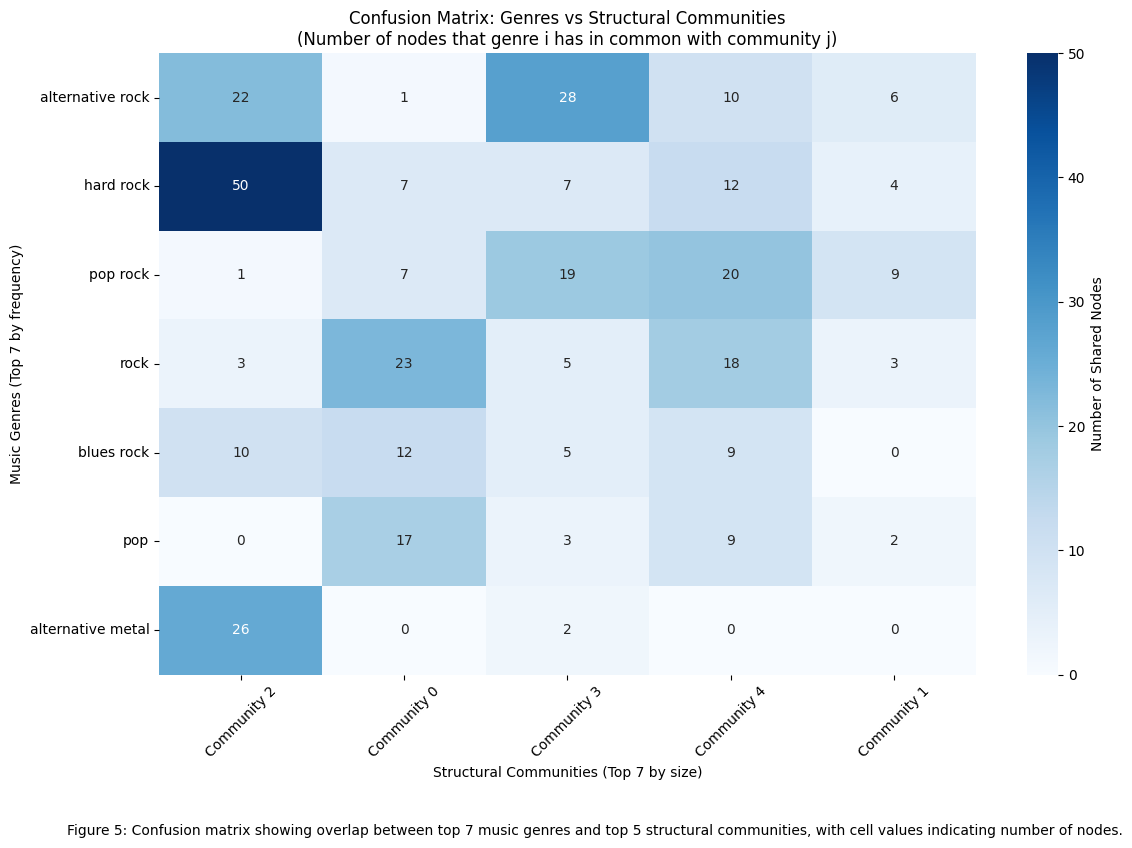


Genre totals (across top 5 communities):
  alternative rock: 67 nodes
  hard rock: 80 nodes
  pop rock: 56 nodes
  rock: 52 nodes
  blues rock: 36 nodes
  pop: 31 nodes
  alternative metal: 28 nodes

Community totals (across top 7 genres):
  Community 2: 112 nodes
  Community 0: 67 nodes
  Community 3: 69 nodes
  Community 4: 78 nodes
  Community 1: 24 nodes


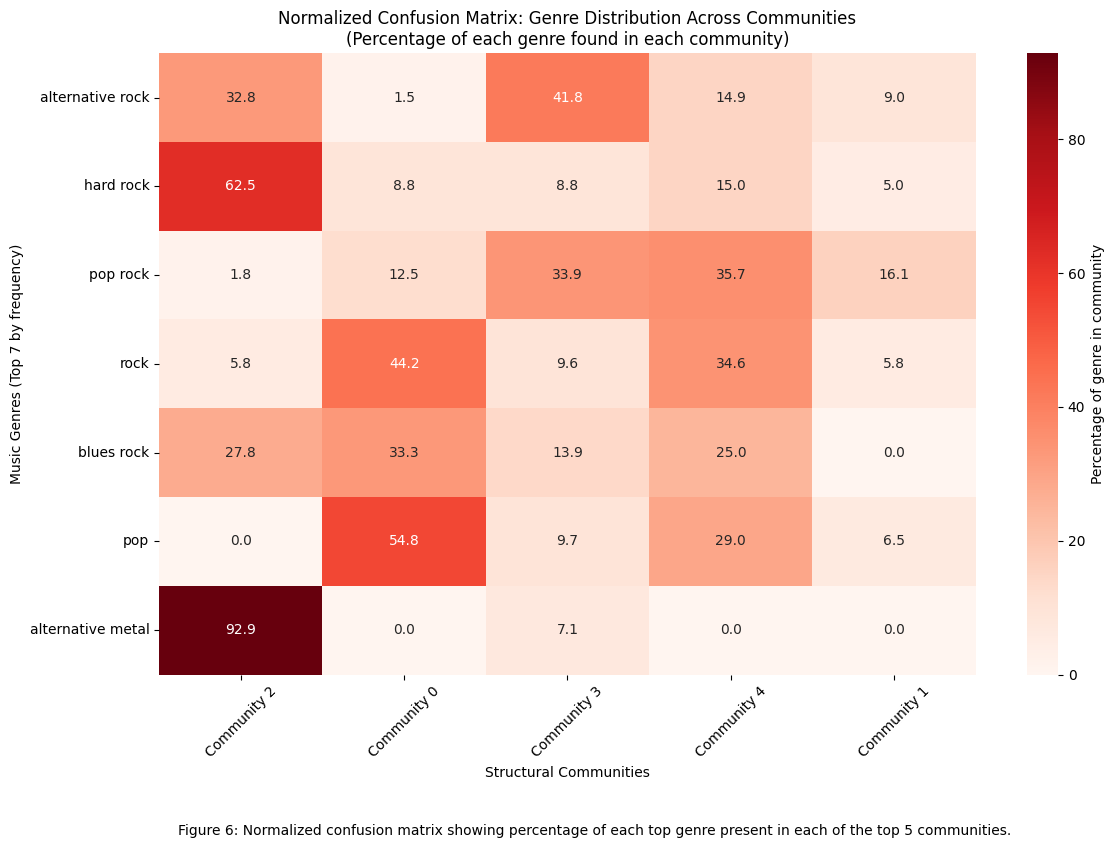

In [156]:
def create_confusion_matrix(G_main, louvain_communities):
    """
    Create a confusion matrix comparing genres with structural communities.
    Uses the 'genre' node attribute from the graph.
    
    Args:
        G_main: NetworkX graph with nodes that have 'genre' attribute
        louvain_communities: List of community sets from Louvain algorithm
        
    Returns:
        tuple: (confusion_matrix, top_genres, top_communities, genre_to_idx, comm_to_idx)
    """
    
    # Create mapping from node to community ID
    node_to_community = {}
    for i, community in enumerate(louvain_communities):
        for node in community:
            node_to_community[node] = i
    
    # Get community sizes and find top 7 largest communities
    community_sizes = [(i, len(community)) for i, community in enumerate(louvain_communities)]
    community_sizes.sort(key=lambda x: x[1], reverse=True)
    top_5_communities = [comm_id for comm_id, size in community_sizes[:5]]
    
    # Count all genre occurrences using the 'genre' node attribute
    all_genre_counts = {}
    for node in G_main.nodes():
        if 'all_genres' in G_main.nodes[node] and G_main.nodes[node]['all_genres']:
            genres_list = G_main.nodes[node]['all_genres']
            for genre in genres_list:
                all_genre_counts[genre] = all_genre_counts.get(genre, 0) + 1
    
    # Get top 7 most common genres
    top_genres_with_counts = sorted(all_genre_counts.items(), key=lambda x: x[1], reverse=True)[:7]
    top_7_genres = [genre for genre, count in top_genres_with_counts]
    
    print("Top 7 genres:")
    for i, (genre, count) in enumerate(top_genres_with_counts):
        print(f"  {i+1}. {genre}: {count} nodes")
    
    print(f"\nTop 5 communities:")
    for i, (comm_id, size) in enumerate(community_sizes[:5]):
        print(f"  {i+1}. Community {comm_id}: {size} nodes")
    
    # Create confusion matrix D (7 genres × 5 communities)
    D = np.zeros((7, 5), dtype=int)
    
    # Create mappings for matrix indices
    genre_to_idx = {genre: i for i, genre in enumerate(top_7_genres)}
    comm_to_idx = {comm_id: i for i, comm_id in enumerate(top_5_communities)}
    
    # Fill the confusion matrix
    for node in G_main.nodes():
        # Check if node is in one of the top 5 communities
        if node in node_to_community and node_to_community[node] in top_5_communities:
            comm_idx = comm_to_idx[node_to_community[node]]
            
            # Check if node has one of the top 7 genres
            if 'all_genres' in G_main.nodes[node] and G_main.nodes[node]['all_genres']:
                genres_list = G_main.nodes[node]['all_genres']
                # For each genre this node has, if it's in top 7, increment matrix
                for genre in genres_list:
                    if genre in genre_to_idx:
                        genre_idx = genre_to_idx[genre]
                        D[genre_idx, comm_idx] += 1

    return D, top_7_genres, top_5_communities, genre_to_idx, comm_to_idx

# Create the confusion matrix
D, top_genres, top_communities, genre_to_idx, comm_to_idx = create_confusion_matrix(G_main, louvain_communities)

print(f"\nConfusion Matrix D ({len(top_genres)} genres × {len(top_communities)} communities):")
print("Rows = Genres, Columns = Communities")
print(f"Matrix shape: {D.shape}")

# Create a pandas DataFrame for better visualization
df_confusion = pd.DataFrame(
    D, 
    index=[f"G{i}: {genre}" for i, genre in enumerate(top_genres)],
    columns=[f"C{i}: Comm{comm_id}" for i, comm_id in enumerate(top_communities)]
)

# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(D, 
            xticklabels=[f"Community {comm_id}" for comm_id in top_communities],
            yticklabels=top_genres,
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar_kws={'label': 'Number of Shared Nodes'})

plt.title('Confusion Matrix: Genres vs Structural Communities\n(Number of nodes that genre i has in common with community j)')
plt.xlabel('Structural Communities (Top 7 by size)')
plt.ylabel('Music Genres (Top 7 by frequency)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.figtext(0.5, -0.05, "Figure 5: Confusion matrix showing overlap between top 7 music genres and top 5 structural communities, with cell values indicating number of nodes.", ha='center', fontsize=10)
plt.tight_layout()
plt.show()


# Calculate row and column sums
row_sums = np.sum(D, axis=1)  # Total nodes per genre (across all top communities)
col_sums = np.sum(D, axis=0)  # Total nodes per community (across all top genres)

print(f"\nGenre totals (across top 5 communities):")
for i, genre in enumerate(top_genres):
    print(f"  {genre}: {row_sums[i]} nodes")

print(f"\nCommunity totals (across top 7 genres):")
for i, comm_id in enumerate(top_communities):
    print(f"  Community {comm_id}: {col_sums[i]} nodes")

# Calculate normalized confusion matrix (percentages)
row_sums_safe = np.where(row_sums == 0, 1, row_sums)
D_normalized_by_row = D / row_sums_safe[:, np.newaxis] * 100

df_normalized = pd.DataFrame(
    D_normalized_by_row, 
    index=[f"{genre}" for genre in top_genres],
    columns=[f"Comm{comm_id}" for comm_id in top_communities]
)

# Visualize normalized matrix
plt.figure(figsize=(12, 8))
sns.heatmap(D_normalized_by_row, 
            xticklabels=[f"Community {comm_id}" for comm_id in top_communities],
            yticklabels=top_genres,
            annot=True, 
            fmt='.1f', 
            cmap='Reds',
            cbar_kws={'label': 'Percentage of genre in community'})

plt.title('Normalized Confusion Matrix: Genre Distribution Across Communities\n(Percentage of each genre found in each community)')
plt.xlabel('Structural Communities')
plt.ylabel('Music Genres (Top 7 by frequency)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.figtext(0.5, -0.05, "Figure 6: Normalized confusion matrix showing percentage of each top genre present in each of the top 5 communities.", ha='center', fontsize=10)
plt.show()

<span style="color:lightblue">

As it can be observed in the normalized confusion matrix, there is quite a good alignment between genres and structural communities. Several patterns emerge from this analysis: Community 2 shows the strongest genre specialization, being mostly formed by metal and hard rock artists. This suggests that metal artists form a cohesive subnetwork, likely due to shared musical influences or collaboration patterns. Community 0 shows a concentration of traditional rock genres, particularly rock and blues rock artists. The genre alternative rock exhibits the most distributed pattern across communities, appearing significantly in multiple structural groups. This suggests that the genre can be a bridge between different musical subcultures. 

This result suggests that musical similarity drives network formation in the rock music ecosystem, and that the structural communities identified by the Louvain algorithm capture not just random connectivity patterns, but meaningful musical relationships.

<span>



# Part 3: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


### TF-IDF intuition and relation to genre and community understanding

#### TF-IDF
Intuitively, in my own words, TF-IDF is an algorithm that -on a high level- helps you vectorize documents for further processing. This vectorization happens through identifying all unique words in a pool of documents and (unlike bag-of-words,) the score that is given to each word shows how important this word is for distinguishing the document in question from the other documents. 

In more detail, TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). The TF component measures how frequently a term appears in a document, while the IDF component reduces the weight of terms that appear frequently across all documents, as they are less informative. The final TF-IDF score is the product of these two values, highlighting terms that are both frequent in a specific document and rare across the corpus. This makes TF-IDF effective for identifying keywords and distinguishing documents.

In this sense, TF-IDF helps us understand genres and communities by identifying the most distinctive words or terms associated with each genre or community. By calculating the TF-IDF scores for words within the text data of artists or communities, we can determine which terms are most representative of a specific genre or community.

### Calculating and visualizing TF-IDF for genres and communities

#### Genres

In [157]:
# Parse artist HTML files and extract genres from the infobox according to the specified structure.

def normalize_genre(g):
    g = g.strip().lower()
    # remove parenthetical comments
    g = re.sub(r"\s*\(.*?\)\s*", "", g)
    # unify various "rock'n'roll" variants to "rock and roll"
    g = re.sub(r"rock\s*['`’]?\s*n\s*['`’]?\s*roll", "rock and roll", g)
    g = re.sub(r"rock\s*&\s*roll", "rock and roll", g)
    g = re.sub(r"rock\s+and\s+roll", "rock and roll", g)
    # replace ampersand with "and"
    g = re.sub(r"&", "and", g)
    # collapse whitespace and strip punctuation at ends
    g = re.sub(r"\s+", " ", g).strip(" ,;:.")
    return g

def get_artist_name(soup, filepath):
    # try common Wikipedia heading
    h = soup.find(id="firstHeading")
    if h and h.get_text(strip=True):
        return h.get_text(strip=True)
    # fallback to title tag
    t = soup.find("title")
    if t and t.get_text(strip=True):
        title = t.get_text(strip=True)
        # often "Artist - Wikipedia"
        return re.sub(r"\s*-\s*Wikipedia.*$", "", title).strip()
    # fallback to filename
    return os.path.splitext(os.path.basename(filepath))[0]

genres_by_artist = OrderedDict()

files = glob.glob("../../Week4/content/**/*.txt", recursive=True)
for fp in tqdm(sorted(files)):
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        # try latin-1 if utf-8 fails
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    soup = BeautifulSoup(html, "html.parser")

    # find the infobox table with the exact class (may have multiple classes)
    table = None
    for tbl in soup.find_all("table", class_=True):
        classes = tbl.get("class", [])
        if "infobox" in classes and "vcard" in classes and "plainlist" in classes:
            table = tbl
            break

    artist = get_artist_name(soup, fp)
    found_genres = []

    if table:
        # find tr where th has class 'infobox-label' and text = 'Genres' (or 'Genre')
        for tr in table.find_all("tr"):
            th = tr.find("th", class_="infobox-label")
            if not th:
                continue
            label = th.get_text(strip=True).lower()
            if label in ("genres", "genre"):
                td = tr.find("td", class_="infobox-data")
                if not td:
                    continue
                # per instruction: genres located in li elements under ul under div.hlist under td.infobox-data
                div = td.find("div", class_="hlist")
                if div:
                    ul = div.find("ul")
                    if ul:
                        for li in ul.find_all("li"):
                            text = li.get_text(" ", strip=True)
                            if text:
                                # sometimes li contains comma-separated items; split conservatively
                                parts = [p.strip() for p in re.split(r"/|,|;| and | \| ", text) if p.strip()]
                                for p in parts:
                                    ng = normalize_genre(p)
                                    if ng:
                                        found_genres.append(ng)
                # if above structure not present, fallback to extracting any links or text in td
                if not found_genres:
                    # gather anchor texts under td
                    anchors = td.find_all("a")
                    if anchors:
                        for a in anchors:
                            text = a.get_text(strip=True)
                            if text:
                                ng = normalize_genre(text)
                                if ng:
                                    found_genres.append(ng)
                    else:
                        # fallback to raw td text splitting on commas
                        raw = td.get_text(" ", strip=True)
                        for p in [x.strip() for x in re.split(r",|/|;|\|| and ", raw) if x.strip()]:
                            ng = normalize_genre(p)
                            if ng:
                                found_genres.append(ng)
                break  # stop after finding the Genres row

    # deduplicate while preserving order
    seen = set()
    uniq = []
    for g in found_genres:
        if g not in seen:
            seen.add(g)
            uniq.append(g)
    if uniq:
        genres_by_artist[artist] = uniq


0it [00:00, ?it/s]


In [158]:
# --- Setup NLTK stopwords ---
try:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words("english"))
except LookupError:
    nltk.download("stopwords")
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words("english"))

extra_stopwords = {"retrieved", "archived", "wikipedia", "cite", "reference", "https", "http"}
stop_words |= extra_stopwords

def clean_and_tokenize_html(html_text):
    """Remove reflist, punctuation, and stopwords; return list of clean tokens."""
    soup = BeautifulSoup(html_text, "html.parser")

    # remove references section <div class="reflist">
    for div in soup.find_all("div", class_="reflist"):
        div.decompose()

    # get visible text
    text = soup.get_text(separator=" ").lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    tokens = re.findall(r"\b[a-z]+\b", text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens


# --- Step 1: Aggregate cleaned text per genre ---
genre_texts = defaultdict(list)  # genre → list of tokens

files = glob.glob("../../Week4/content/**/*.txt", recursive=True)
for fp in tqdm(files, desc="Processing HTML pages"):
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()

    soup = BeautifulSoup(html, "html.parser")

    # get artist name (same logic as before)
    title = soup.find(id="firstHeading")
    if title:
        artist_name = title.get_text(strip=True)
    else:
        artist_name = re.sub(r"- Wikipedia.*$", "", soup.title.string if soup.title else fp)
        artist_name = artist_name.strip()

    # skip artists without genre info
    if artist_name not in genres_by_artist:
        continue

    tokens = clean_and_tokenize_html(html)

    # assign the same text to each genre this artist belongs to
    for g in genres_by_artist[artist_name]:
        genre_texts[g].extend(tokens)


# --- Step 2: Keep only the top 15 genres ---
top_15_genres = [
    g for g, _ in Counter(g for lst in genres_by_artist.values() for g in lst).most_common(15)
]

genre_documents = {}
for genre in top_15_genres:
    # join tokens back into a single long string
    genre_documents[genre] = " ".join(genre_texts[genre])

# Optional: save each genre’s document to disk
os.makedirs("genre_docs", exist_ok=True)
for genre, text in genre_documents.items():
    safe_name = re.sub(r"\W+", "_", genre.lower())
    path = os.path.join("genre_docs", f"{safe_name}.txt")
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)

print(f"✅ Created {len(genre_documents)} genre documents.")


Processing HTML pages: 0it [00:00, ?it/s]

✅ Created 0 genre documents.


In [159]:
# TF-IDF wordclouds for top genres (uses variables defined in earlier cells:
# genre_texts, top_15_genres, top_15_genres, top_n etc.)

# 1) Build term frequencies per-genre (Counter) from existing genre_texts
tf_by_genre = {g: Counter(genre_texts.get(g, [])) for g in top_15_genres}

# 2) Document frequency (in how many genre-docs a term appears)
N = len(top_15_genres)
df = Counter()
for g, ctr in tf_by_genre.items():
    for w in ctr:
        df[w] += 1

# 3) IDF: smooth idf: idf(w) = 1 + ln( N / (1 + df(w)) )
idf = {w: 1.0 + math.log(N / (1 + df_w),  math.e) for w, df_w in df.items()}

# 4) TF variant: sublinear tf: tf' = 1 + ln(tf)  (if tf>0), then TF-IDF = tf' * idf
tfidf_by_genre = {}
for g, ctr in tf_by_genre.items():
    tfidf = {}
    for w, raw_tf in ctr.items():
        if raw_tf <= 0:
            continue
        tf_sub = 1.0 + math.log(raw_tf, math.e)  # sublinear TF
        tfidf[w] = tf_sub * idf.get(w, 1.0)
    tfidf_by_genre[g] = tfidf

# 5) Show top 10 TF-IDF terms per genre
print("Top 10 TF-IDF words per genre (sublinear TF, smooth natural-log IDF):\n")
top_k = 10
top_terms_by_genre = {}
for g in top_15_genres:
    tfidf = tfidf_by_genre.get(g, {})
    top_terms = sorted(tfidf.items(), key=lambda x: -x[1])[:top_k]
    top_terms_by_genre[g] = top_terms
    print(f"=== {g} ===")
    for w, score in top_terms:
        print(f"{w}\t{score:.4f}")
    print()

# 6) Create wordclouds using TF-IDF weights (scaled)
try:
    cols = 3
    rows = (len(top_15_genres) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 4))
    for i, g in enumerate(top_15_genres):
        freqs = tfidf_by_genre.get(g, {})
        if not freqs:
            continue
        # scale to a nicer range for WordCloud; preserve relative ordering
        max_val = max(freqs.values())
        scaled = {w: (v / max_val) * 100.0 for w, v in freqs.items()}

        wc = WordCloud(width=600, height=400, background_color="white",
                       collocations=False).generate_from_frequencies(scaled)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(g.title())
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("WordCloud not available or error generating images:", e)
    print("Top terms printed above. To enable wordclouds, install the `wordcloud` package.")

# 7) Save top terms to a dict for later inspection
_top_tfidf_terms_15genres = top_terms_by_genre

Top 10 TF-IDF words per genre (sublinear TF, smooth natural-log IDF):



<Figure size 1500x0 with 0 Axes>

#### Communities

In [161]:
# Modularities of genre-based partitions (new cell)

G = nx.read_gexf('rock_performers_graph.gexf')

# genres_by_artist is defined in a previous cell (from the scraping step)
if "genres_by_artist" not in globals():
    raise RuntimeError("genres_by_artist not found. Run the previous cell that builds genres_by_artist.")

# Attempt robust name matching from artist keys to graph node names (case-insensitive)
artist_to_node = {}
nodes_by_lower = {str(n).lower(): n for n in G.nodes()}
for artist in genres_by_artist.keys():
    a_low = artist.lower()
    if artist in G:
        artist_to_node[artist] = artist  # exact match
    elif a_low in nodes_by_lower:
        artist_to_node[artist] = nodes_by_lower[a_low]
    else:
        # try relaxed matching: compare normalized whitespace/underscores
        norm = a_low.replace("_", " ").strip()
        matched = None
        for node in G.nodes():
            node_norm = str(node).lower().replace("_", " ").strip()
            if node_norm == norm:
                matched = node
                break
        if matched:
            artist_to_node[artist] = matched

matched = {a: artist_to_node[a] for a in artist_to_node}
unmatched_count = len(genres_by_artist) - len(matched)
print(f"Artists with genre info: {len(genres_by_artist)}; matched to nodes in graph: {len(matched)}; unmatched: {unmatched_count}")

# Build the subgraph containing only nodes for which we have genre info and were matched
mapped_nodes = set(matched.values())
H = G.subgraph(mapped_nodes).copy()
m = H.number_of_edges()
if m == 0:
    raise RuntimeError("Subgraph has zero edges; cannot compute modularity.")

# helper: compute modularity from communities (communities: iterable of node lists)
def modularity_from_communities(G_in, communities):
    m_edges = G_in.number_of_edges()
    if m_edges == 0:
        return 0.0
    Q = 0.0
    for C in communities:
        L_c = G_in.subgraph(C).number_of_edges()             # internal edges
        D_c = sum(dict(G_in.degree(C)).values())             # sum of degrees (in G_in)
        Q += (L_c / m_edges) - (D_c / (2 * m_edges)) ** 2
    return Q

# Partition 1: first-genre for each artist -> community labels
node_to_artist = {v: k for k, v in matched.items()}

Artists with genre info: 0; matched to nodes in graph: 0; unmatched: 0


RuntimeError: Subgraph has zero edges; cannot compute modularity.

top terms per comm: 100%|██████████| 8/8 [00:00<00:00, 236.55it/s]


=== comm_0 (size=514684 tokens, unique=28643) ===
kantner	13.7907
dury	13.4692
ulvaeus	12.7207
balin	12.6891
gouldman	12.6571
gilmour	11.7265
hollies	11.7265
lumineers	11.7215
lyngstad	11.6733
hite	11.6241
kaukonen	11.5739
burchill	11.3616
gibbins	11.3055
sylvain	11.1890
polley	11.1286

=== comm_1 (size=323100 tokens, unique=20825) ===
anselmo	13.4461
scholz	12.7519
howerdel	12.1165
ellefson	11.9920
emeritus	11.9490
coheed	11.7215
hanneman	11.4165
cherone	11.3616
firehouse	11.3055
delp	11.1890
tuck	11.0666
lindemann	11.0030
inez	10.9376
heafy	10.9376
ibanez	10.9376

=== comm_2 (size=250031 tokens, unique=17810) ===
murphey	13.9271
rea	13.7091
croce	13.1766
ondrasik	12.5245
shorrock	12.3840
tork	12.0757
goble	11.5739
mcvie	11.5290
outfield	11.3055
birtles	11.2480
negron	11.0030
deyoung	10.8704
kirwan	10.8704
nesmith	10.8497
kale	10.6566

=== comm_3 (size=235080 tokens, unique=17079) ===
wentz	12.7519
delonge	12.1960
nowell	11.9490
urie	11.8151
mcilrath	11.3055
gaugh	11.3055
farro	11.128

generate wordclouds: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


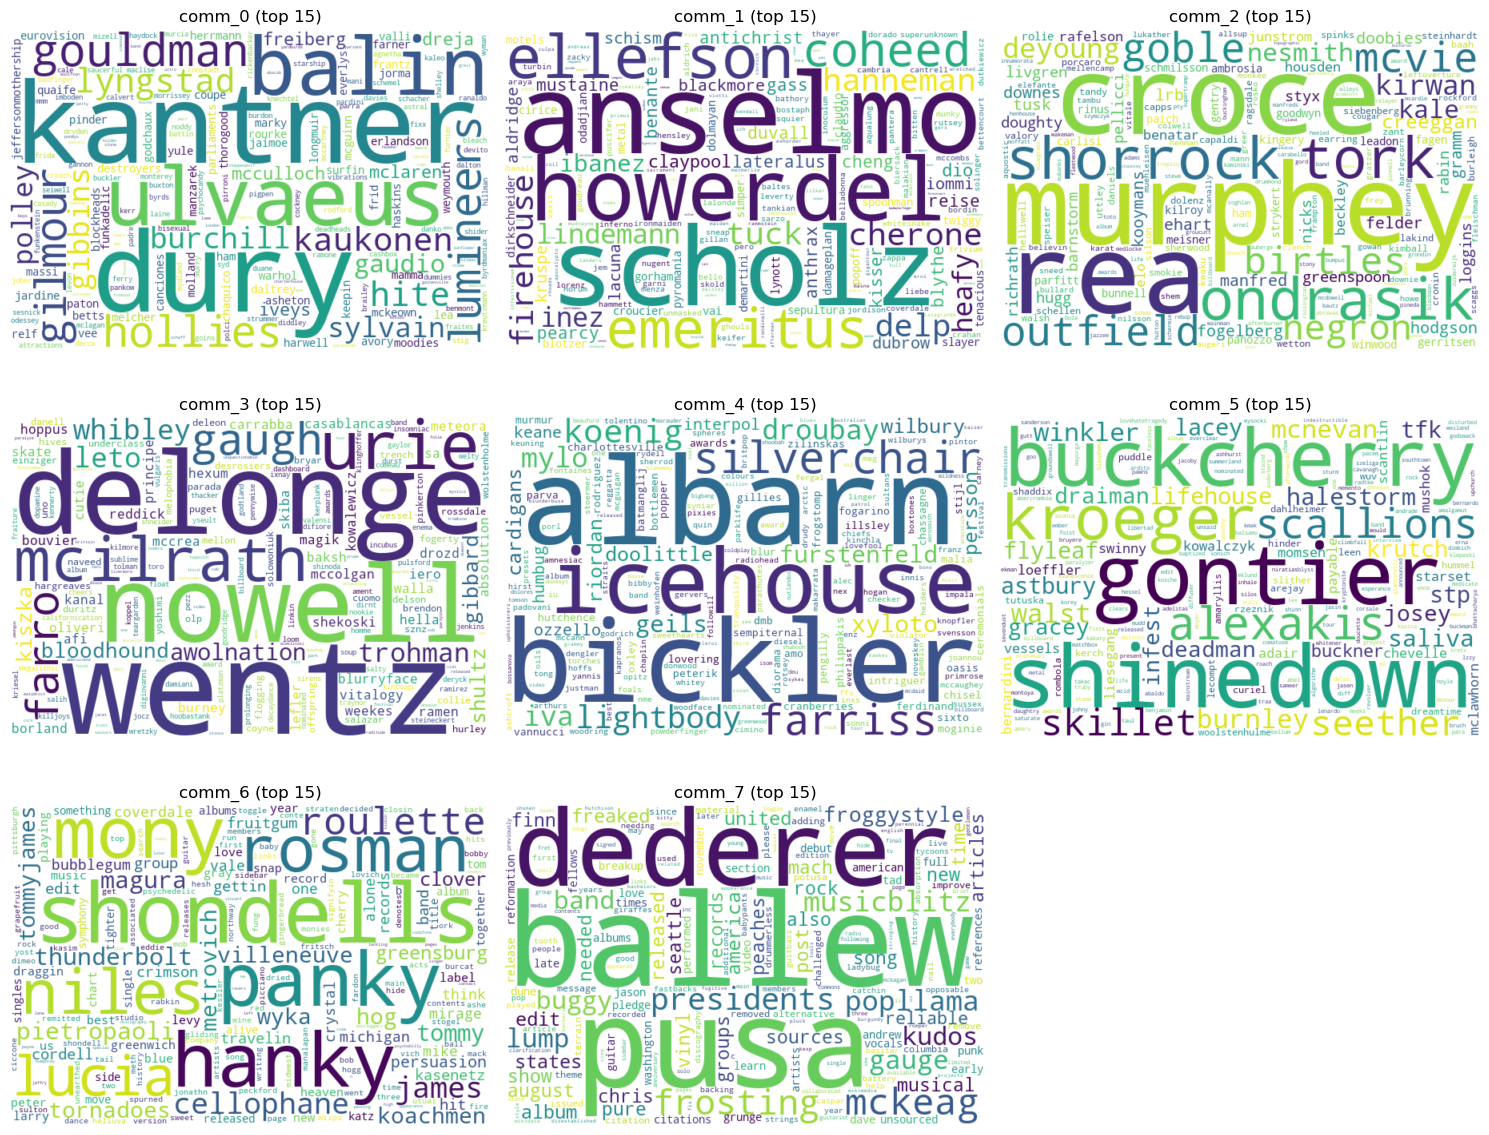

In [ ]:
# Community word-clouds for the 15 largest structural communities
# Uses notebook variables: H, node_to_artist, clean_and_tokenize_html (from earlier cells)

# Load Louvain communities from a JSON file

with open("louvain_comms.json", "r") as f:
    comms = json.load(f)

# take 15 largest structural communities
top_n = 15
comms_sorted = sorted(comms, key=len, reverse=True)
top_comms_15 = [list(c) for c in comms_sorted[:top_n]]

# build artist -> filepath map by scanning HTML files (robust lookup)
artist_file = {}
files = glob.glob("../../Week4/content/**/*.txt", recursive=True)
for fp in tqdm(files, desc="scanning files"):
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    soup = BeautifulSoup(html, "html.parser")
    title = soup.find(id="firstHeading")
    if title and title.get_text(strip=True):
        name = title.get_text(strip=True)
    elif soup.title and soup.title.string:
        name = re.sub(r"- Wikipedia.*$", "", soup.title.string).strip()
    else:
        name = os.path.splitext(os.path.basename(fp))[0]
    artist_file[name] = fp

# helper to get tokens for an artist
def tokens_for_artist(artist_name):
    fp = artist_file.get(artist_name)
    if not fp:
        return []
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    return clean_and_tokenize_html(html)

# aggregate tokens per community
comm_tokens = {}
for i, comm in enumerate(tqdm(top_comms_15, desc="communities")):
    ctr = Counter()
    for node in tqdm(comm, desc=f"nodes in comm_{i}", leave=False):
        artist = node_to_artist.get(node)
        if not artist:
            continue
        toks = tokens_for_artist(artist)
        if toks:
            ctr.update(toks)
    comm_tokens[f"comm_{i}"] = ctr

# Build TF-IDF across the top N community documents
docs = list(comm_tokens.keys())
Ndocs = len(docs)
# Document frequency
df = Counter()
for g, ctr in tqdm(comm_tokens.items(), desc="document frequency"):
    for w in ctr:
        df[w] += 1

# IDF: smooth natural-log idf
idf = {w: 1.0 + math.log(Ndocs / (1 + df_w)) for w, df_w in df.items()}

# TF variant: sublinear (1 + ln(tf)); compute TF-IDF
tfidf_by_comm = {}
for g, ctr in tqdm(comm_tokens.items(), desc="compute tfidf"):
    tfidf = {}
    for w, raw_tf in tqdm(ctr.items(), desc=f"tf terms {g}", leave=False):
        if raw_tf <= 0:
            continue
        tf_sub = 1.0 + math.log(raw_tf)
        tfidf[w] = tf_sub * idf.get(w, 1.0)
    tfidf_by_comm[g] = tfidf

# show top 15 TF-IDF words per community
top_k = 15
top_terms_by_comm = {}
for g in tqdm(docs, desc="top terms per comm"):
    top_terms = sorted(tfidf_by_comm.get(g, {}).items(), key=lambda x: -x[1])[:top_k]
    top_terms_by_comm[g] = top_terms
    print(f"=== {g} (size={sum(comm_tokens[g].values())} tokens, unique={len(comm_tokens[g])}) ===")
    for w, s in top_terms:
        print(f"{w}\t{s:.4f}")
    print()

# WordClouds (scaled TF-IDF)
try:
    cols = 3
    rows = (len(docs) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 4))
    for i, g in enumerate(tqdm(docs, desc="generate wordclouds")):
        freqs = tfidf_by_comm.get(g, {})
        if not freqs:
            continue
        max_val = max(freqs.values()) if freqs else 1.0
        scaled = {w: (v / max_val) * 100.0 for w, v in freqs.items()}
        wc = WordCloud(width=600, height=400, background_color="white", collocations=False)
        wc = wc.generate_from_frequencies(scaled)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{g} (top {top_k})")
    plt.tight_layout()
    plt.figtext(0.5, -0.02, "Figure 7: Word clouds showing the top TF-IDF terms for the 15 largest structural communities of rock performers, highlighting distinctive themes per community.", ha='center', fontsize=10)
    plt.show()
except Exception as e:
    print("WordCloud not available or error:", e)
    print("Top terms printed above.")

### Difference between genres and communities with matrix D from Lecture 7

Top 7 genres (rows): ['alternative rock', 'hard rock', 'pop rock', 'rock', 'alternative metal', 'heavy metal', 'post-grunge']
Top 7 structural communities sizes (cols): [100, 72, 69, 62, 57, 46, 1]

Confusion matrix D (rows=genres, cols=communities):

[[11  7  1 46 27 27  0]
 [10 36 17  8  6 32  0]
 [11  4 18 18 14  7  0]
 [36  3 16  4 10  1  0]
 [ 0 22  0  6  1 23  0]
 [ 2 28  1  0  1  4  0]
 [ 0  2  0  6  2 28  0]]


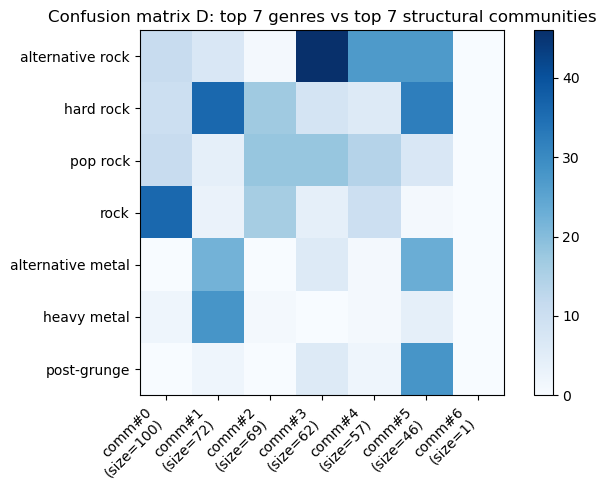

In [ ]:

# Compare Louvain structural communities with top genres -> confusion matrix D (7x7)
# Relies on notebook variables: H, genres_by_artist, node_to_artist (from earlier cells)

# 1) load Louvain communities from JSON file
with open("louvain_comms.json", "r") as f:
    comms_all = json.load(f)

# 2) take the 7 largest structural communities
top = all_genres.most_common(top_n)
comms_sorted = sorted(comms_all, key=len, reverse=True)
topC = 7
top_comms = [list(c) for c in comms_sorted[:topC]]
comm_sizes = [len(c) for c in top_comms]

# 3) determine the 7 most common genres (from earlier 'all_genres' / 'top' if present)
try:
    top_genres_list = [g for g, _ in top[:7]]
except Exception:
    # compute from genres_by_artist if 'top' not present
    allg = Counter(g for genres in genres_by_artist.values() for g in genres)
    top_genres_list = [g for g, _ in allg.most_common(7)]

G = len(top_genres_list)
C = len(top_comms)

# 4) build maps for quick lookup
genre_to_row = {g: i for i, g in enumerate(top_genres_list)}
node_to_commidx = {}
for j, comm in enumerate(top_comms):
    for n in comm:
        node_to_commidx[n] = j

# 5) build confusion matrix D (G x C)
D = np.zeros((G, C), dtype=int)

for node in H.nodes():
    # only consider nodes that are in one of the top C communities
    if node not in node_to_commidx:
        continue
    comm_idx = node_to_commidx[node]

    # map node -> artist name -> genres
    artist = node_to_artist.get(node)
    if artist is None:
        continue
    genres = genres_by_artist.get(artist, [])
    # consider all genres associated with the node; ignore node if none in top genres
    intersect = [g for g in genres if g in genre_to_row]
    if not intersect:
        continue
    for g in intersect:
        D[genre_to_row[g], comm_idx] += 1

# 6) display results
print("Top 7 genres (rows):", top_genres_list)
print("Top 7 structural communities sizes (cols):", comm_sizes)
print("\nConfusion matrix D (rows=genres, cols=communities):\n")
print(D)

# 7) visualize as heatmap
plt.figure(figsize=(8,5))
im = plt.imshow(D, cmap="Blues", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(C), [f"comm#{i}\n(size={s})" for i, s in enumerate(comm_sizes)], rotation=45, ha="right")
plt.yticks(range(G), top_genres_list)
plt.title("Confusion matrix D: top 7 genres vs top 7 structural communities")
plt.tight_layout()
plt.figtext(0.5, -0.02, "Figure 8: Confusion matrix showing the overlap between the top 7 music genres (rows) and the 7 largest structural communities (columns) in the network, with color intensity representing the number of nodes shared.", ha='center', fontsize=10)
plt.show()

### Discussion

The confusion matrix D shows how the top 7 music genres overlap with the top 7 structural communities, revealing that while some genres align closely with specific communities (e.g., alternative rock with **comm#3**, rock with **comm#0**, and hard rock with **comm#1**/**comm#5**), most exhibit substantial cross-membership. This explains the difference between the genre-based and community-based word clouds. Genre word clouds display stylistically coherent groupings—such as *Delonge* and *Albarn* in alternative rock or *Dubrow* and *Kisser* in heavy metal—reflecting traditional, sound-based categorization. In contrast, community word clouds mix artists from adjacent genres (e.g., *Delonge*, *Wentz*, *Kroeger*, *Skillet* in **comm#3–5**), highlighting clusters formed through shared collaborations, band membership, or social ties. Thus, the confusion matrix clarifies that network-derived communities capture empirical connectivity across genre boundaries, whereas genre labels describe conceptual stylistic coherence.


# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

### Sentiment of band/artist pages

In [ ]:

df = pd.read_csv('labmt.txt', sep='\t')

In [ ]:
def calculate_sentiment(tokens: list, word_scores: pd.DataFrame) -> float:
    """
    Calculate the average sentiment score of a list of tokens based on the provided word scores DataFrame.

    Parameters:
    tokens (list): A list of words (tokens) for which to calculate the sentiment.
    word_scores (pd.DataFrame): A DataFrame containing words and their corresponding sentiment scores.

    Returns:
    float: The average sentiment score of the tokens. Returns 0 if no tokens have a score.
    """
    # Convert the DataFrame to a dictionary for faster lookups
    word_score_dict = dict(zip(word_scores['word'], word_scores['happiness_average']))

    total_score = 0
    count = 0

    for token in tokens:
        if token in word_score_dict:
            total_score += word_score_dict[token]
            count += 1

    return total_score / count if count > 0 else 0

In [ ]:
# Load the graph
G = rock_network

# Iterate over nodes and calculate sentiment
content_folder = "artist_pages/"
for node_id in tqdm(G.nodes):
    # Find the corresponding HTML page txt file
    file_path = os.path.join(content_folder, f"{node_id}.txt")
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        
        # Tokenize the text
        tokens = word_tokenize(text.lower())
        # print(f'Tokenized {node_id}: {len(tokens)}', end='\r')  # Print number of tokens for verification
        # Calculate sentiment
        sentiment = calculate_sentiment(tokens, df)
        # print(f'Calculated sentiment for {node_id}: {sentiment}', end='\r')  # Print sentiment for verification
        # Add sentiment as a nodal feature
        G.nodes[node_id]['sentiment'] = sentiment

# Save the updated graph
output_path = "./rock_performers_graph_sentiment.gexf"
nx.write_gexf(G, output_path)

100%|██████████| 485/485 [01:19<00:00,  6.12it/s]


In [ ]:
G.nodes(data=True)

NodeDataView({'Slayer': {'word_count': 16624, 'label': 'Slayer', 'sentiment': 5.44227233304459}, 'Ted_Nugent': {'word_count': 11733, 'label': 'Ted_Nugent', 'sentiment': 5.4099722442508895}, 'Great_White': {'word_count': 7026, 'label': 'Great_White', 'sentiment': 5.528249455027949}, 'Days_of_the_New': {'word_count': 3462, 'label': 'Days_of_the_New', 'sentiment': 5.45315704088247}, 'The_Dave_Clark_Five': {'word_count': 2989, 'label': 'The_Dave_Clark_Five', 'sentiment': 5.465915700048955}, 'Keane_(band)': {'word_count': 7782, 'label': 'Keane_(band)', 'sentiment': 5.497917048388426}, 'Jimmy_Eat_World': {'word_count': 5475, 'label': 'Jimmy_Eat_World', 'sentiment': 5.554360205083442}, 'Flogging_Molly': {'word_count': 2337, 'label': 'Flogging_Molly', 'sentiment': 5.474355294629191}, 'Simple_Plan': {'word_count': 6862, 'label': 'Simple_Plan', 'sentiment': 5.539527968779048}, 'Foreigner_(band)': {'word_count': 9733, 'label': 'Foreigner_(band)', 'sentiment': 5.499498822993526}, 'Steppenwolf_(ban

Mean Sentiment: 5.485640958088458
Median Sentiment: 5.485594902948533
Variance: 0.001430311308246757
25th Percentile: 5.4619862574438525
75th Percentile: 5.508072512919954


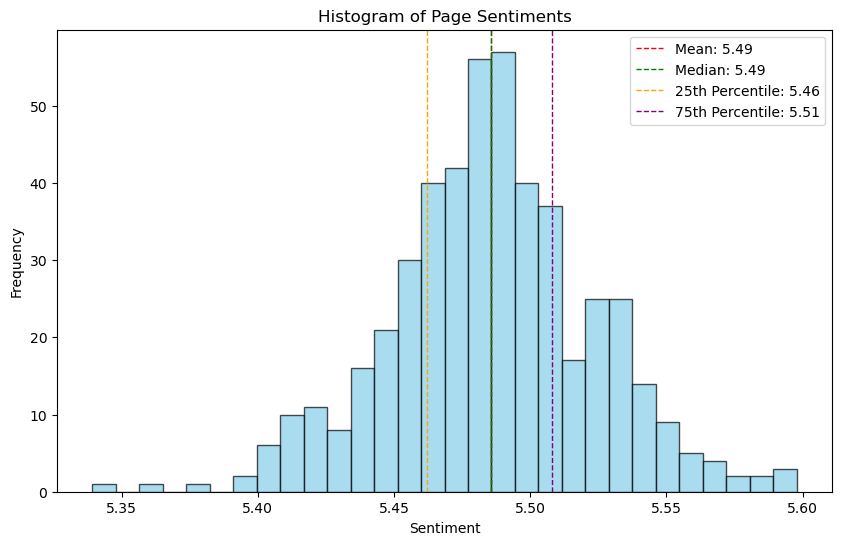

10 Saddest Artists:
Five_Finger_Death_Punch 5.339253908693132
Rage_Against_the_Machine 5.358653827589804
Rob_Zombie 5.373939242280398
Quiet_Riot 5.393716227554903
Canned_Heat 5.395937638213116
Traffic_(band) 5.399931086142283
Gary_Glitter 5.402677170589288
Drowning_Pool 5.40288112726717
Poison_(American_band) 5.404811468970925
No_Doubt 5.4058339136491105

10 Happiest Artists:
Air_Supply 5.568498791686759
Imagine_Dragons 5.569118134470019
Simple_Minds 5.570005341880715
Fun_(band) 5.573765361297617
Kenny_Loggins 5.575635852911066
Michael_Martin_Murphey 5.5852717510409
Train_(band) 5.5875156130998995
Lenny_Kravitz 5.590038381677717
The_Beach_Boys 5.591865110951487
Boys_Like_Girls 5.597888276795305


In [ ]:
# Extract sentiment values from the graph
sentiments = [data['sentiment'] for _, data in G.nodes(data=True) if 'sentiment' in data]

# Calculate statistics
mean_sentiment = np.mean(sentiments)
median_sentiment = np.median(sentiments)
variance_sentiment = np.var(sentiments)
percentile_25 = np.percentile(sentiments, 25)
percentile_75 = np.percentile(sentiments, 75)

# Print statistics
print(f"Mean Sentiment: {mean_sentiment}")
print(f"Median Sentiment: {median_sentiment}")
print(f"Variance: {variance_sentiment}")
print(f"25th Percentile: {percentile_25}")
print(f"75th Percentile: {percentile_75}")

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(sentiments, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sentiment:.2f}')
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_sentiment:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentile_75:.2f}')
plt.title('Histogram of Page Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.figtext(0.5, -0.02, "Figure 9: Histogram of sentiment scores across artist pages, with dashed lines marking the mean (red), median (green), 25th percentile (orange), and 75th percentile (purple), showing the distribution of positive and negative sentiment.", ha='center', fontsize=10)
plt.legend()
plt.show()

# Find the 10 happiest and saddest artists
sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1].get('sentiment', 0))
saddest_artists = sorted_nodes[:10]
happiest_artists = sorted_nodes[-10:]

print("10 Saddest Artists:")
for artist in saddest_artists:
    print(artist[0], artist[1].get('sentiment', 0))

print("\n10 Happiest Artists:")
for artist in happiest_artists:
    print(artist[0], artist[1].get('sentiment', 0))

### Sentiment of communities

In [ ]:
# Load the communities
with open('louvain_comms.json', 'r') as file:
    communities = json.load(file)

# Calculate community-level sentiment
community_sentiments = []
for community in communities:
    community_sentiment = [G.nodes[band_id]['sentiment'] for band_id in community if 'sentiment' in G.nodes[band_id]]
    avg_sentiment = np.mean(community_sentiment) if community_sentiment else 0
    community_sentiments.append((community, avg_sentiment))

# Sort communities by average sentiment
community_sentiments.sort(key=lambda x: x[1])

# Save the new json along with average sentiments
community_sentiments_serializable = [{
    'community': community,
    'average_sentiment': avg_sentiment
} for community, avg_sentiment in community_sentiments]

with open('louvain_comms_sentiments.json', 'w') as file:
    json.dump(community_sentiments_serializable, file)

In [ ]:
# Name each community by its three most connected bands
community_names = []
for community, _ in community_sentiments:
    band_degrees = [(band_id, G.degree(band_id)) for band_id in community]
    top_bands = sorted(band_degrees, key=lambda x: x[1], reverse=True)[:3]
    top_band_names = [band[0] for band in top_bands]
    community_names.append(top_band_names)

# Find the happiest and saddest communities
happiest_communities = community_sentiments[-3:]
saddest_communities = community_sentiments[:3]

# Print results
print("Happiest Communities:")
for i, (community, sentiment) in enumerate(happiest_communities, 1):
    print(f"{i}. Bands: {community_names[communities.index(community)]}, Sentiment: {sentiment:.2f}")

print("\nSaddest Communities:")
for i, (community, sentiment) in enumerate(saddest_communities, 1):
    print(f"{i}. Bands: {community_names[communities.index(community)]}, Sentiment: {sentiment:.2f}")

# Compare to overall sentiment
print("\nComparison to Overall Sentiment:")
print(f"Overall Mean Sentiment: {mean_sentiment:.2f}")
print(f"Variance: {variance_sentiment:.2f}")
for i, (community, sentiment) in enumerate(community_sentiments, 1):
    print(f"Community {i} Sentiment: {sentiment:.2f}, Difference from Mean: {sentiment - mean_sentiment:.2f}")

Happiest Communities:
1. Bands: ['Tommy_James_and_the_Shondells'], Sentiment: 5.50
2. Bands: ['Nickelback', 'Daughtry_(band)', 'Stone_Temple_Pilots'], Sentiment: 5.50
3. Bands: ['U2', 'Aerosmith', 'Coldplay'], Sentiment: 5.51

Saddest Communities:
1. Bands: ['Black_Sabbath', 'Metallica', 'Korn'], Sentiment: 5.44
2. Bands: ['The_Beatles', 'Led_Zeppelin', 'The_Rolling_Stones'], Sentiment: 5.47
3. Bands: ['Red_Hot_Chili_Peppers', 'Green_Day', 'Foo_Fighters'], Sentiment: 5.48

Comparison to Overall Sentiment:
Overall Mean Sentiment: 5.49
Variance: 0.00
Community 1 Sentiment: 5.44, Difference from Mean: -0.05
Community 2 Sentiment: 5.47, Difference from Mean: -0.02
Community 3 Sentiment: 5.48, Difference from Mean: -0.01
Community 4 Sentiment: 5.49, Difference from Mean: -0.00
Community 5 Sentiment: 5.50, Difference from Mean: 0.01
Community 6 Sentiment: 5.50, Difference from Mean: 0.01
Community 7 Sentiment: 5.50, Difference from Mean: 0.01
Community 8 Sentiment: 5.51, Difference from Mean

### Recreating TF-IDF results from Week 7

In [ ]:
def clean_and_tokenize_html(html_text):
    """Remove reflist, punctuation, and stopwords; return list of clean tokens."""
    soup = BeautifulSoup(html_text, "html.parser")

    # remove references section <div class="reflist">
    for div in soup.find_all("div", class_="reflist"):
        div.decompose()

    # get visible text
    text = soup.get_text(separator=" ").lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    tokens = re.findall(r"\b[a-z]+\b", text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

def normalize_genre(g):
    g = g.strip().lower()
    # remove parenthetical comments
    g = re.sub(r"\s*\(.*?\)\s*", "", g)
    # unify various "rock'n'roll" variants to "rock and roll"
    g = re.sub(r"rock\s*['`’]?\s*n\s*['`’]?\s*roll", "rock and roll", g)
    g = re.sub(r"rock\s*&\s*roll", "rock and roll", g)
    g = re.sub(r"rock\s+and\s+roll", "rock and roll", g)
    # replace ampersand with "and"
    g = re.sub(r"&", "and", g)
    # collapse whitespace and strip punctuation at ends
    g = re.sub(r"\s+", " ", g).strip(" ,;:.")
    return g

def get_artist_name(soup, filepath):
    # try common Wikipedia heading
    h = soup.find(id="firstHeading")
    if h and h.get_text(strip=True):
        return h.get_text(strip=True)
    # fallback to title tag
    t = soup.find("title")
    if t and t.get_text(strip=True):
        title = t.get_text(strip=True)
        # often "Artist - Wikipedia"
        return re.sub(r"\s*-\s*Wikipedia.*$", "", title).strip()
    # fallback to filename
    return os.path.splitext(os.path.basename(filepath))[0]

genres_by_artist = OrderedDict()

files = glob.glob("artist_pages/**/*.txt", recursive=True)
for fp in sorted(files):
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        # try latin-1 if utf-8 fails
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    soup = BeautifulSoup(html, "html.parser")

    # find the infobox table with the exact class (may have multiple classes)
    table = None
    for tbl in soup.find_all("table", class_=True):
        classes = tbl.get("class", [])
        if "infobox" in classes and "vcard" in classes and "plainlist" in classes:
            table = tbl
            break

    artist = get_artist_name(soup, fp)
    found_genres = []

    if table:
        # find tr where th has class 'infobox-label' and text = 'Genres' (or 'Genre')
        for tr in table.find_all("tr"):
            th = tr.find("th", class_="infobox-label")
            if not th:
                continue
            label = th.get_text(strip=True).lower()
            if label in ("genres", "genre"):
                td = tr.find("td", class_="infobox-data")
                if not td:
                    continue
                # per instruction: genres located in li elements under ul under div.hlist under td.infobox-data
                div = td.find("div", class_="hlist")
                if div:
                    ul = div.find("ul")
                    if ul:
                        for li in ul.find_all("li"):
                            text = li.get_text(" ", strip=True)
                            if text:
                                # sometimes li contains comma-separated items; split conservatively
                                parts = [p.strip() for p in re.split(r"/|,|;| and | \| ", text) if p.strip()]
                                for p in parts:
                                    ng = normalize_genre(p)
                                    if ng:
                                        found_genres.append(ng)
                # if above structure not present, fallback to extracting any links or text in td
                if not found_genres:
                    # gather anchor texts under td
                    anchors = td.find_all("a")
                    if anchors:
                        for a in anchors:
                            text = a.get_text(strip=True)
                            if text:
                                ng = normalize_genre(text)
                                if ng:
                                    found_genres.append(ng)
                    else:
                        # fallback to raw td text splitting on commas
                        raw = td.get_text(" ", strip=True)
                        for p in [x.strip() for x in re.split(r",|/|;|\|| and ", raw) if x.strip()]:
                            ng = normalize_genre(p)
                            if ng:
                                found_genres.append(ng)
                break  # stop after finding the Genres row

    # deduplicate while preserving order
    seen = set()
    uniq = []
    for g in found_genres:
        if g not in seen:
            seen.add(g)
            uniq.append(g)
    if uniq:
        genres_by_artist[artist] = uniq

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tzikos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
artist_to_node = {}
nodes_by_lower = {str(n).lower(): n for n in G.nodes()}
for artist in genres_by_artist.keys():
    a_low = artist.lower()
    if artist in G:
        artist_to_node[artist] = artist  # exact match
    elif a_low in nodes_by_lower:
        artist_to_node[artist] = nodes_by_lower[a_low]
    else:
        # try relaxed matching: compare normalized whitespace/underscores
        norm = a_low.replace("_", " ").strip()
        matched = None
        for node in G.nodes():
            node_norm = str(node).lower().replace("_", " ").strip()
            if node_norm == norm:
                matched = node
                break
        if matched:
            artist_to_node[artist] = matched

matched = {a: artist_to_node[a] for a in artist_to_node}
node_to_artist = {v: k for k, v in matched.items()}


top terms per comm: 100%|██████████| 8/8 [00:00<00:00, 277.47it/s]


=== Community 1 (size=516315 tokens, unique=28649) ===
kantner	13.7907
dury	13.4692
ulvaeus	12.7207
balin	12.6891
gouldman	12.6571
gilmour	11.7265
hollies	11.7265
lumineers	11.7215
lyngstad	11.6733
hite	11.6241
kaukonen	11.5739
burchill	11.3616
gibbins	11.3055
sylvain	11.1890
polley	11.1286

=== Community 2 (size=324384 tokens, unique=20831) ===
anselmo	13.4461
scholz	12.7519
howerdel	12.1165
ellefson	11.9920
emeritus	11.9490
coheed	11.7215
hanneman	11.4165
cherone	11.3616
firehouse	11.3055
delp	11.1890
tuck	11.0666
lindemann	11.0030
inez	10.9376
heafy	10.9376
ibanez	10.9376

=== Community 3 (size=250865 tokens, unique=17816) ===
murphey	13.9271
rea	13.7091
croce	13.1766
ondrasik	12.5245
shorrock	12.3840
tork	12.0757
goble	11.5739
mcvie	11.5290
outfield	11.3055
birtles	11.2480
negron	11.0030
deyoung	10.8704
kirwan	10.8704
nesmith	10.8497
kale	10.6566

=== Community 4 (size=235842 tokens, unique=17086) ===
wentz	12.7519
delonge	12.1960
nowell	11.9490
urie	11.8151
mcilrath	11.3055
gaugh	

generate wordclouds: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


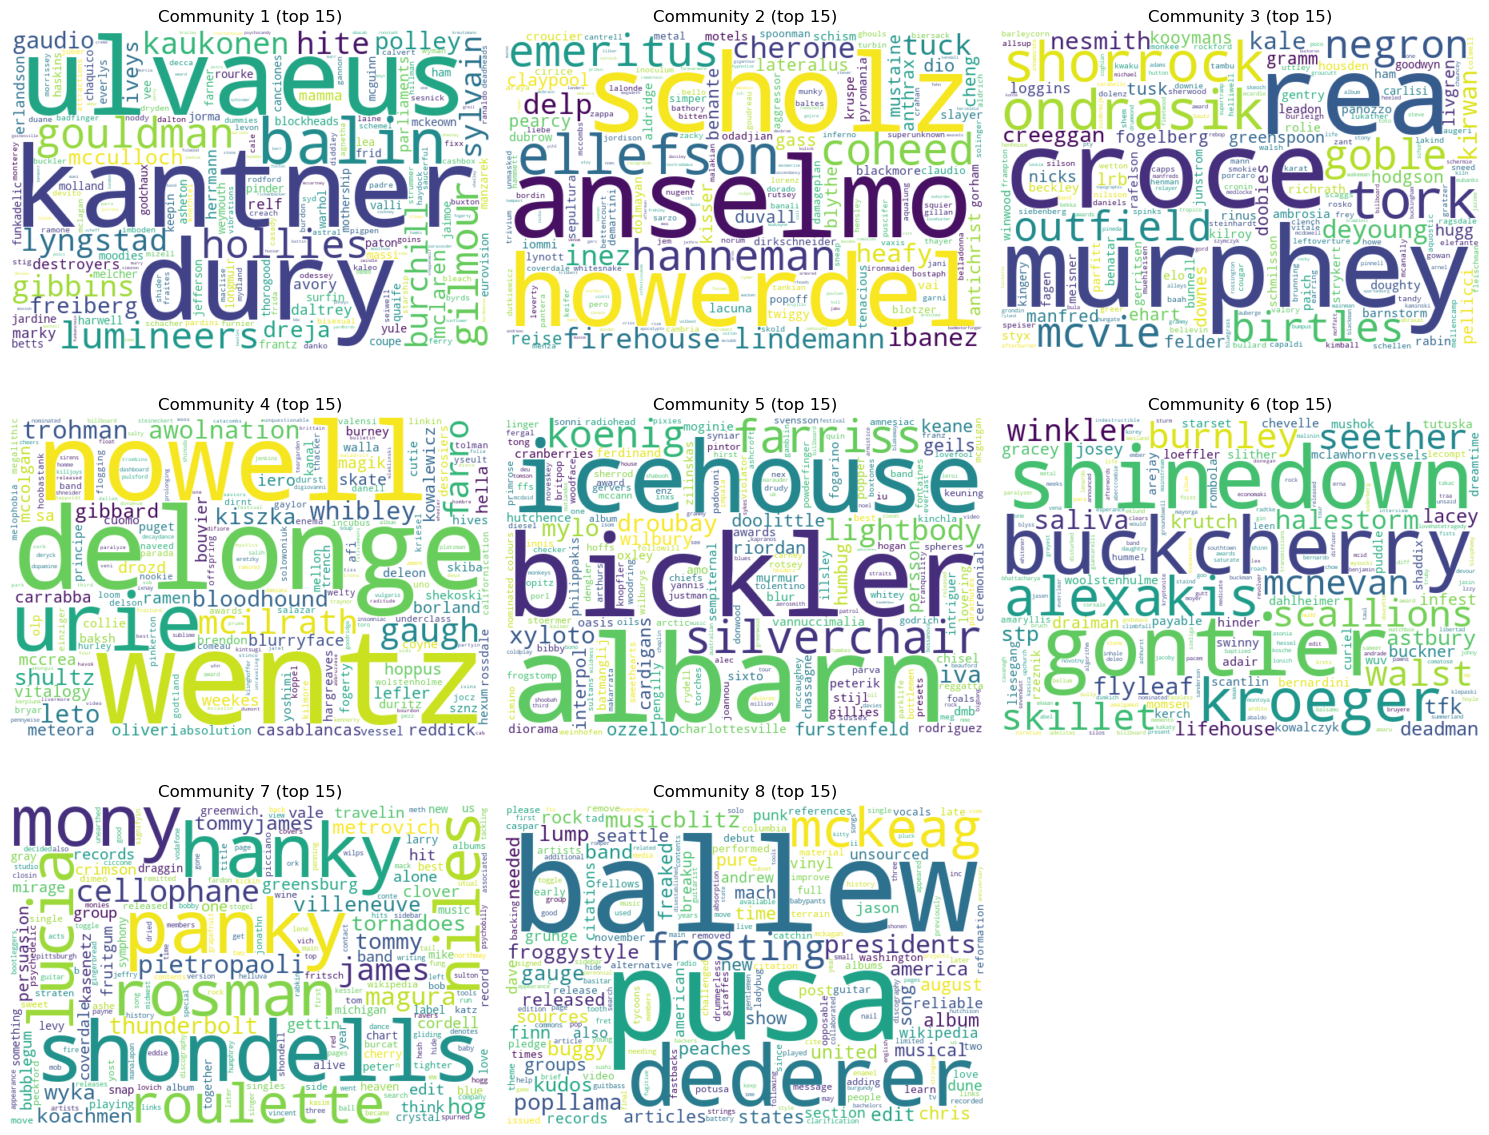

In [ ]:
# ensure we have Louvain communities available, else compute
comms = communities

# take 15 largest structural communities
top_n = 15
comms_sorted = sorted(comms, key=len, reverse=True)
top_comms_15 = [list(c) for c in comms_sorted[:top_n]]

# build artist -> filepath map by scanning HTML files (robust lookup)
artist_file = {}
files = glob.glob("artist_pages/**/*.txt", recursive=True)
for fp in tqdm(files, desc="scanning files"):
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    soup = BeautifulSoup(html, "html.parser")
    title = soup.find(id="firstHeading")
    if title and title.get_text(strip=True):
        name = title.get_text(strip=True)
    elif soup.title and soup.title.string:
        name = re.sub(r"- Wikipedia.*$", "", soup.title.string).strip()
    else:
        name = os.path.splitext(os.path.basename(fp))[0]
    artist_file[name] = fp

# helper to get tokens for an artist
def tokens_for_artist(artist_name):
    fp = artist_file.get(artist_name)
    if not fp:
        return []
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    return clean_and_tokenize_html(html)

# aggregate tokens per community
comm_tokens = {}
for i, comm in enumerate(tqdm(top_comms_15, desc="communities")):
    ctr = Counter()
    for node in tqdm(comm, desc=f"nodes in comm_{i}", leave=False):
        artist = node_to_artist.get(node)
        if not artist:
            continue
        toks = tokens_for_artist(artist)
        if toks:
            ctr.update(toks)
    comm_tokens[f"Community {i+1}"] = ctr

# Build TF-IDF across the top N community documents
docs = list(comm_tokens.keys())
Ndocs = len(docs)
# Document frequency
df = Counter()
for g, ctr in tqdm(comm_tokens.items(), desc="document frequency"):
    for w in ctr:
        df[w] += 1

# IDF: smooth natural-log idf
idf = {w: 1.0 + math.log(Ndocs / (1 + df_w)) for w, df_w in df.items()}

# TF variant: sublinear (1 + ln(tf)); compute TF-IDF
tfidf_by_comm = {}
for g, ctr in tqdm(comm_tokens.items(), desc="compute tfidf"):
    tfidf = {}
    for w, raw_tf in tqdm(ctr.items(), desc=f"tf terms {g}", leave=False):
        if raw_tf <= 0:
            continue
        tf_sub = 1.0 + math.log(raw_tf)
        tfidf[w] = tf_sub * idf.get(w, 1.0)
    tfidf_by_comm[g] = tfidf

# show top 15 TF-IDF words per community
top_k = 15
top_terms_by_comm = {}
for g in tqdm(docs, desc="top terms per comm"):
    top_terms = sorted(tfidf_by_comm.get(g, {}).items(), key=lambda x: -x[1])[:top_k]
    top_terms_by_comm[g] = top_terms
    print(f"=== {g} (size={sum(comm_tokens[g].values())} tokens, unique={len(comm_tokens[g])}) ===")
    for w, s in top_terms:
        print(f"{w}\t{s:.4f}")
    print()

# WordClouds (scaled TF-IDF)
try:
    cols = 3
    rows = (len(docs) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 4))
    for i, g in enumerate(tqdm(docs, desc="generate wordclouds")):
        freqs = tfidf_by_comm.get(g, {})
        if not freqs:
            continue
        max_val = max(freqs.values()) if freqs else 1.0
        scaled = {w: (v / max_val) * 100.0 for w, v in freqs.items()}
        wc = WordCloud(width=600, height=400, background_color="white", collocations=False)
        wc = wc.generate_from_frequencies(scaled)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{g} (top {top_k})")
    plt.tight_layout()
    plt.figtext(0.5, -0.02, "Figure 10: Word clouds of the 15 largest structural communities, where word size reflects scaled TF-IDF importance, highlighting the most distinctive terms associated with each community.", ha='center', fontsize=10)
    plt.show()
except Exception as e:
    print("WordCloud not available or error:", e)
    print("Top terms printed above.")

# expose results for later use
_comm_tokens_15 = comm_tokens
_tfidf_by_comm_15 = tfidf_by_comm
_top_terms_by_comm_15 = top_terms_by_comm

### Comparison and discussion

#### Sentiment of the Communities

The sentiment analysis reveals that the differences in sentiment across communities are minimal, with the overall mean sentiment being 5.49 and a variance close to zero. The happiest communities have slightly higher sentiment values (5.50–5.51), while the saddest communities have slightly lower values (5.44–5.48). These differences are subtle, indicating that the sentiment distribution is relatively uniform across the network.

##### Happiest Communities:
1. **Bands like Tommy James and the Shondells** and **U2, Aerosmith, Coldplay** are associated with slightly higher sentiment scores. These bands are often linked to uplifting or mainstream music, which may contribute to their higher sentiment.

2. **Nickelback, Daughtry, and Stone Temple Pilots** also show higher sentiment, possibly due to their association with accessible and emotionally resonant music.

##### Saddest Communities:
1. **Bands like Black Sabbath, Metallica, and Korn** are associated with lower sentiment scores. These bands are known for darker, heavier themes, which might explain their slightly lower sentiment.

2. **The Beatles, Led Zeppelin, and The Rolling Stones** have a slightly lower sentiment, which could be influenced by the diversity of their discographies, including melancholic or introspective tracks.

3. **Red Hot Chili Peppers, Green Day, and Foo Fighters** also show lower sentiment, potentially reflecting their mix of upbeat and emotionally charged music.

#### Insights from TF-IDF Analysis

The TF-IDF results provide additional context for understanding the sentiment differences:

1. **Community-Specific Keywords**:
    - Communities with higher sentiment scores (e.g., Community 7 and Community 8) have keywords like "shondells," "hanky," "panky," and "ballew," which are associated with lighthearted or niche topics. These terms suggest a focus on specific, less emotionally intense themes.
    - Communities with lower sentiment scores (e.g., Community 1 and Community 2) feature keywords like "kantner," "gilmour," "anselmo," and "hanneman," which are tied to artists or bands known for complex, darker, or heavier themes.

2. **Community Size and Diversity**:
    - Larger communities (e.g., Community 1 and Community 2) have more diverse tokens and themes, which might dilute sentiment scores and lead to a more neutral average.
    - Smaller communities (e.g., Community 7 and Community 8) are more focused, with keywords reflecting specific genres or bands, potentially leading to more distinct sentiment scores.

3. **Genre Influence**:
    - Communities with higher sentiment often align with genres like pop rock or mainstream rock, which are generally perceived as more uplifting.
    - Communities with lower sentiment align with genres like heavy metal or alternative rock, which often explore darker or more introspective themes.

#### Conclusion

The TF-IDF findings help contextualize the sentiment results by highlighting the thematic focus of each community. Communities with keywords tied to lighter or niche topics tend to have higher sentiment, while those with keywords linked to heavier or more complex themes show lower sentiment. This suggests that the sentiment of a community is influenced by the genres, themes, and artists that dominate its content.

## Contributions

